In [1]:
import numpy as np
from maelstrom import Maelstrom
import matplotlib.pyplot as plt


%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 300

In [2]:
import numpy as np
from lightkurve import search_lightcurvefile

def get_lightcurve(target, **kwargs):
    lc_collection = search_lightcurvefile(target, **kwargs).download_all()

    lc = lc_collection[0].PDCSAP_FLUX.normalize()
    for l in lc_collection[1:]:
        lc = lc.append(l.PDCSAP_FLUX.normalize())

    lc = lc.remove_nans()
    magnitude = -2.5 * np.log10(lc.flux)
    magnitude = magnitude - np.average(magnitude)
    return lc.time, lc.flux

time, mag = get_lightcurve('KIC 6780873', cadence='long')
#time -= np.mean(time)
#mag *= 1000
t, y = time, mag# / 1e3
#time = time[:len(time)//2]
#mag = mag[:len(mag)//2]

In [210]:
%run paper/notebooks/setup.py

In [3]:
ms = Maelstrom(t, y, max_peaks=2, fmin=10, fmax=24)
#ax = ms.plot_time_delay_periodogram(segment_size=5.5, annotate=False, max_period=300)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ec01f60>,
      dtype=object)

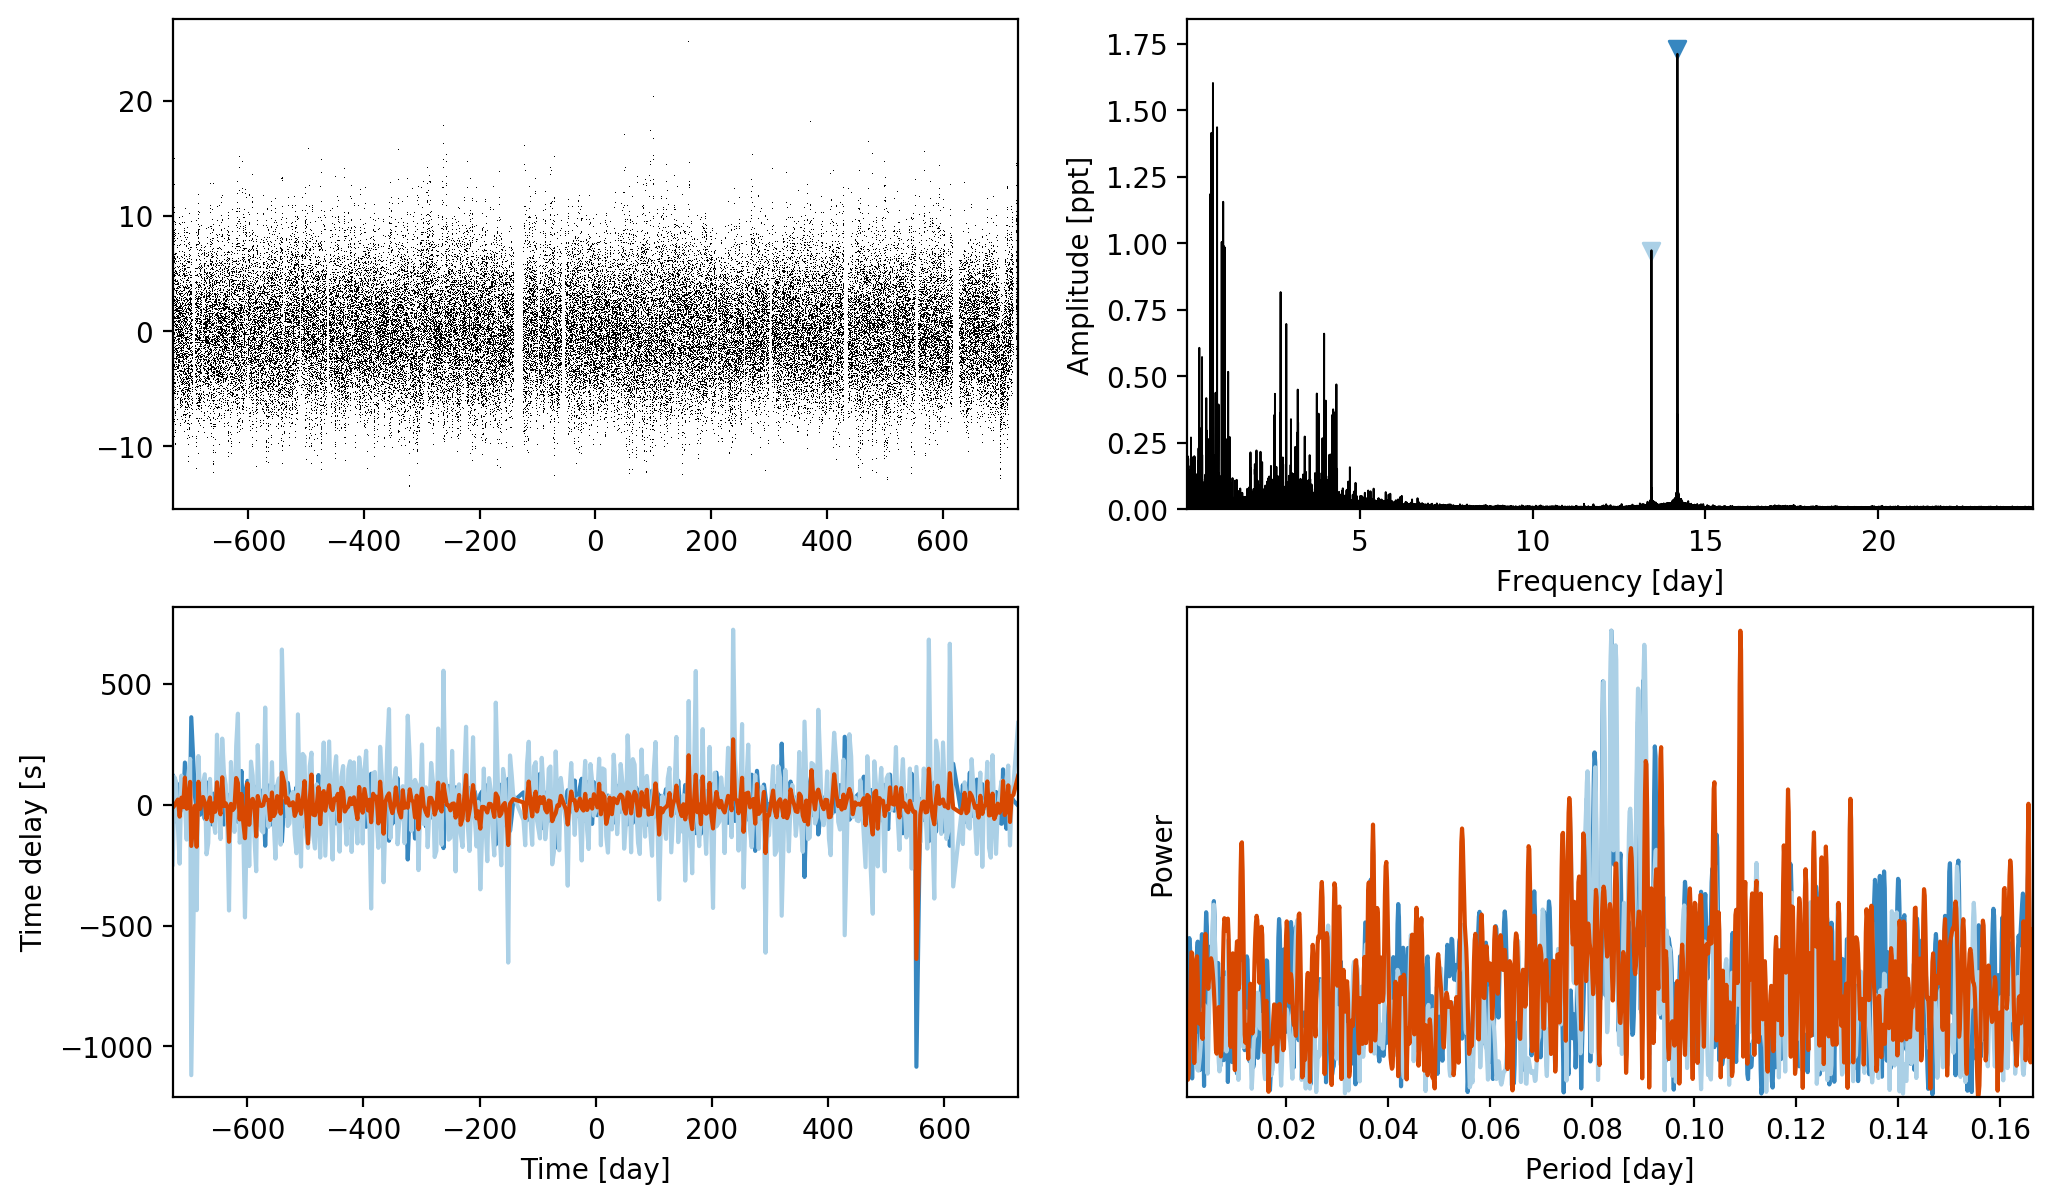

In [5]:
ms.first_look(segment_size=3.)

In [5]:
pg = ms.period_search()

In [15]:
periods = np.linspace(2, 15, 50)

results = pg.fit(periods)

100%|██████████| 50/50 [01:20<00:00,  1.56s/it]


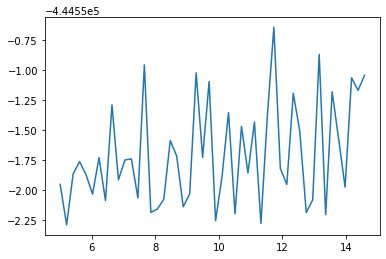

In [53]:
ys = np.array([[r[0] for r in row] for row in results])
#sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], ys[0][:-2]);

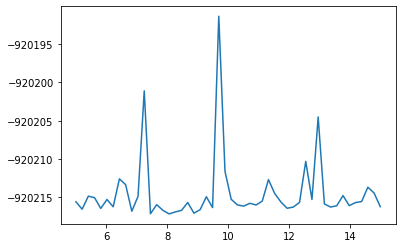

In [49]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods, sm);

In [4]:
time, mag = ms.time, ms.flux
freq = ms.freq

In [9]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import pymc3 as pm

with pm.Model() as model:
    # It's much faster to sample from a log-space period
#     logP = pm.Normal("logP", mu=np.log(9.15), sd=3.)
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(9.15), sd=1.0,
                                      testval=np.log(9.15))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=0.)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(50))('logasini', mu=np.log(19.6), sd=1,
                                            testval=np.log(19.6))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    psi = -tt.sin(M)
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(ms.freq), sd=0.1, shape=len(ms.freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(ms.freq))
    log_min_amp = np.log(0.1 * np.std(mag))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(mag))
    log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=10.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean

    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
#     pm.Deterministic("gp_pred", gp.predict())

    trace = pm.load_trace(directory='traces/6780873/')

In [20]:
import theano

with model:
    func = xo.utils.get_theano_function_for_var(model.logpt, profile=True)
#     func = xo.utils.get_theano_function_for_var(theano.grad(model.logpt, model.vars), profile=True)
    args = xo.utils.get_args_for_theano_function(model.test_point)
    print(func(*args))
    
    %timeit func(*args)

-419419.01525025524
10.1 ms ± 91.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
func.profile.summary()

Function profiling
  Message: /Users/danielhey/anaconda3/lib/python3.7/site-packages/exoplanet/utils.py:35
  Time in 812 calls to Function.__call__: 8.097940e+00s
  Time in Function.fn.__call__: 8.044399e+00s (99.339%)
  Time in thunks: 7.936235e+00s (98.003%)
  Total compile time: 3.907491e+00s
    Number of Apply nodes: 111
    Theano Optimizer time: 7.920232e-01s
       Theano validate time: 1.676798e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 2.836088e+00s
       Import time 2.628424e-01s
       Node make_thunk time 2.831490e+00s
           Node Elemwise{Composite{(i0 * sin((((i1 * i2 * i3) - (i4 * i2 * i5 * i6)) - i7)))}}(Elemwise{Exp}[(0, 0)].0, TensorConstant{(1, 1) of ..5307179586}, Elemwise{exp,no_inplace}.0, TensorConstant{[[-729.744..74449125]]}, TensorConstant{(1, 1) of ..664304e-05}, Elemwise{Exp}[(0, 0)].0, Elemwise{Composite{sin(((i0 / i1) - i2))}}.0, Elemwise{arctan2,no_inplace}.0) time 9.923790e-01s
           Node Elemwise{Composite{sin((

[phi_angle__, logs_lc, mean, lognu, phase_angle__, logamp_interval__, logw0_interval__, logpower]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -419635.0726871437 -> -419635.0588319594
optimizing logp for variables: ['logs_lc']
message: Optimization terminated successfully.
logp: -419635.0588319594 -> -182113.1714978377
optimizing logp for variables: ['logw0_interval__', 'logpower']
message: Desired error not necessarily achieved due to precision loss.
logp: -182113.1714978377 -> -170865.2765075161
optimizing logp for variables: ['logamp_interval__', 'phase_angle__']
message: Desired error not necessarily achieved due to precision loss.
logp: -170865.2765075161 -> -161660.71100585055
optimizing logp for variables: ['phi_angle__']
message: Optimization terminated successfully.
logp: -161660.71100585055 -> -161637.6963447744
optimizing logp for variables: ['lognu']
message: Desired error not necessarily achieved due to precision loss.
logp: 

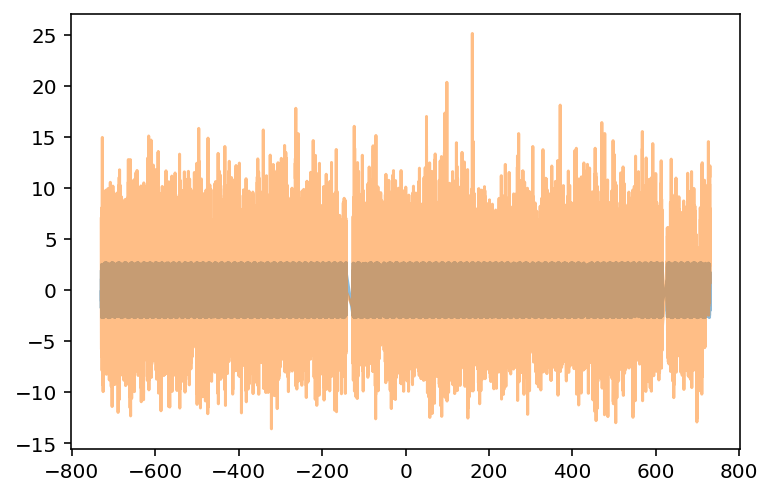

In [29]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    #map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

In [57]:
map_params

{'logP_interval__': array(-1.03121554),
 'phi_angle__': array([-3.79191577, -2.37094388]),
 'logs_lc': array(-1.30812392),
 'logasini_interval__': array(-0.60801949),
 'mean': array(0.00798465),
 'lognu': array([2.65237127, 2.5979628 ]),
 'phase_angle__': array([[ 3.30153609, -2.93128102],
        [-3.01659755,  3.37751281]]),
 'logamp_interval__': array([ 0.59810561, -0.44808984]),
 'logw0_interval__': array(1.27172436),
 'logpower': array(10.82300999),
 'logP': array(2.21466898),
 'period': array(9.15837702),
 'phi': array(-2.1295846),
 'logasini': array(2.86992984),
 'asini': array(17.63578083),
 'nu': array([14.18764155, 13.43633764]),
 'phase': array([ 2.3111265 , -0.71478405]),
 'logamp': array([ 0.54925686, -0.03884124]),
 'logw0': array(2.62792478),
 'logS0': array(0.31131088)}

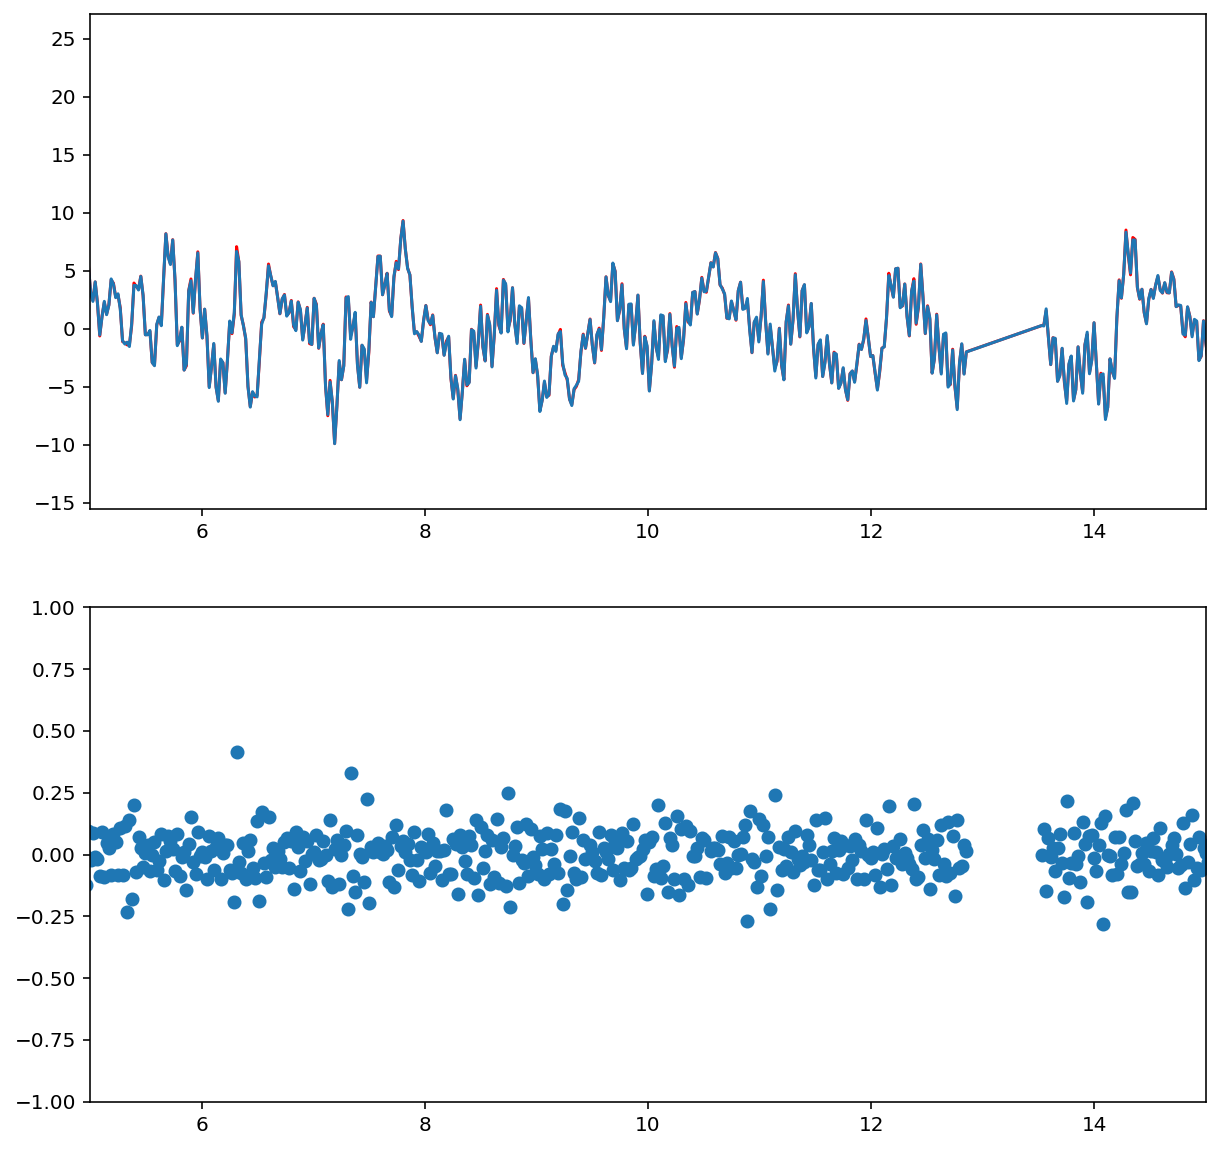

In [36]:
fig, axes = plt.subplots(2,1, figsize=[10,10])

with model:
    ax = axes[0]
    ax.plot(time, mag, c='r')
    #plt.plot(time, xo.eval_in_model(full_lc, map_params))
    ax.plot(time, xo.eval_in_model(full_lc + gp.predict(), map_params))
    ax.set_xlim(5, 15)
    
    ax = axes[1]
    ax.scatter(time, mag - xo.eval_in_model(full_lc + gp.predict(), map_params))
    ax.set_xlim(5, 15)
    ax.set_ylim(-1,1)

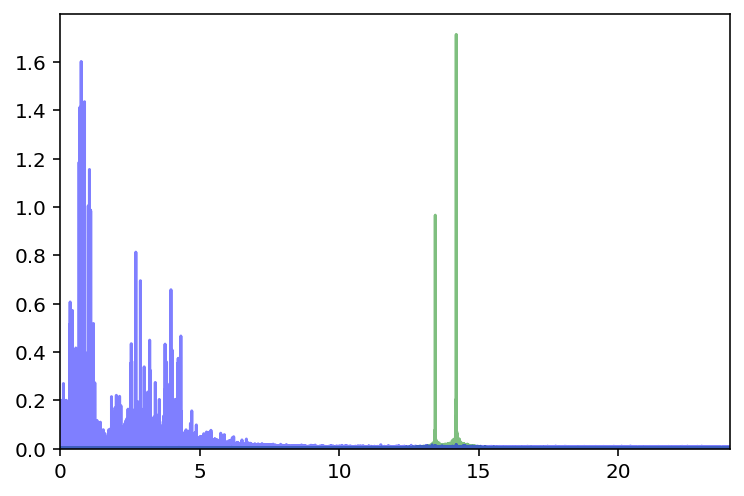

In [45]:
from maelstrom.utils import amplitude_spectrum

with model:
    #plt.plot(*amplitude_spectrum(time, mag), c='r', alpha=0.25)
    plt.plot(*amplitude_spectrum(time, xo.eval_in_model(full_lc, map_params)), c='g', alpha=0.5)
    plt.plot(*amplitude_spectrum(time, xo.eval_in_model(gp.predict(), map_params)), c='b', alpha=0.5)
    plt.xlim(0,24)
    plt.ylim(0, None)

In [68]:
ms.freq

array([14.18764197, 13.43633836])

In [31]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains: 100%|██████████| 1004/1004 [02:42<00:00,  4.60draws/s]


In [59]:
with model:
    trace = sampler.sample(draws=2000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [logpower, logw0, logamp, phase, lognu, mean, logasini, logs_lc, phi, logP]
>NUTS: [logpower, logw0, logamp, phase, lognu, mean, logasini, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 4000/4000 [10:46<00:00,  5.24draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.


In [25]:
param = 'phi'
med = np.median(trace[param])
per = np.percentile(trace[param], [84.15, 15.86])
print(med, med-per[1], per[0]-med)

-2.130735862073172 0.08248586998357421 0.08252494416112865


In [11]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-1.248038,5.469332e-03,6.086839e-05,-1.259388,-1.237903,8882.533210,0.999829
mean,0.079427,7.618868e-01,8.728785e-03,-1.337669,1.615806,8334.819155,0.999827
lognu__0,2.652371,3.252224e-08,3.540890e-10,2.652371,2.652371,8527.671837,0.999842
lognu__1,2.597963,6.511003e-08,7.306175e-10,2.597963,2.597963,9075.780858,0.999835
logpower,10.555333,8.412417e-03,8.696787e-05,10.537868,10.570656,7667.752916,0.999910
logP,2.214672,2.912455e-04,3.316200e-06,2.214114,2.215251,8109.086302,0.999764
period,9.158402,2.667342e-03,3.036975e-05,9.153291,9.163709,8109.903051,0.999764
phi,-2.129988,8.355339e-02,7.569390e-04,-2.296029,-1.972178,8736.058617,0.999761
logasini,2.884876,8.371401e-02,1.091305e-03,2.727755,3.055542,7256.933137,0.999856
asini,17.963714,1.489411e+00,1.886240e-02,14.937733,20.821441,7537.850401,0.999868


In [48]:
2.667342e-03

0.002667342

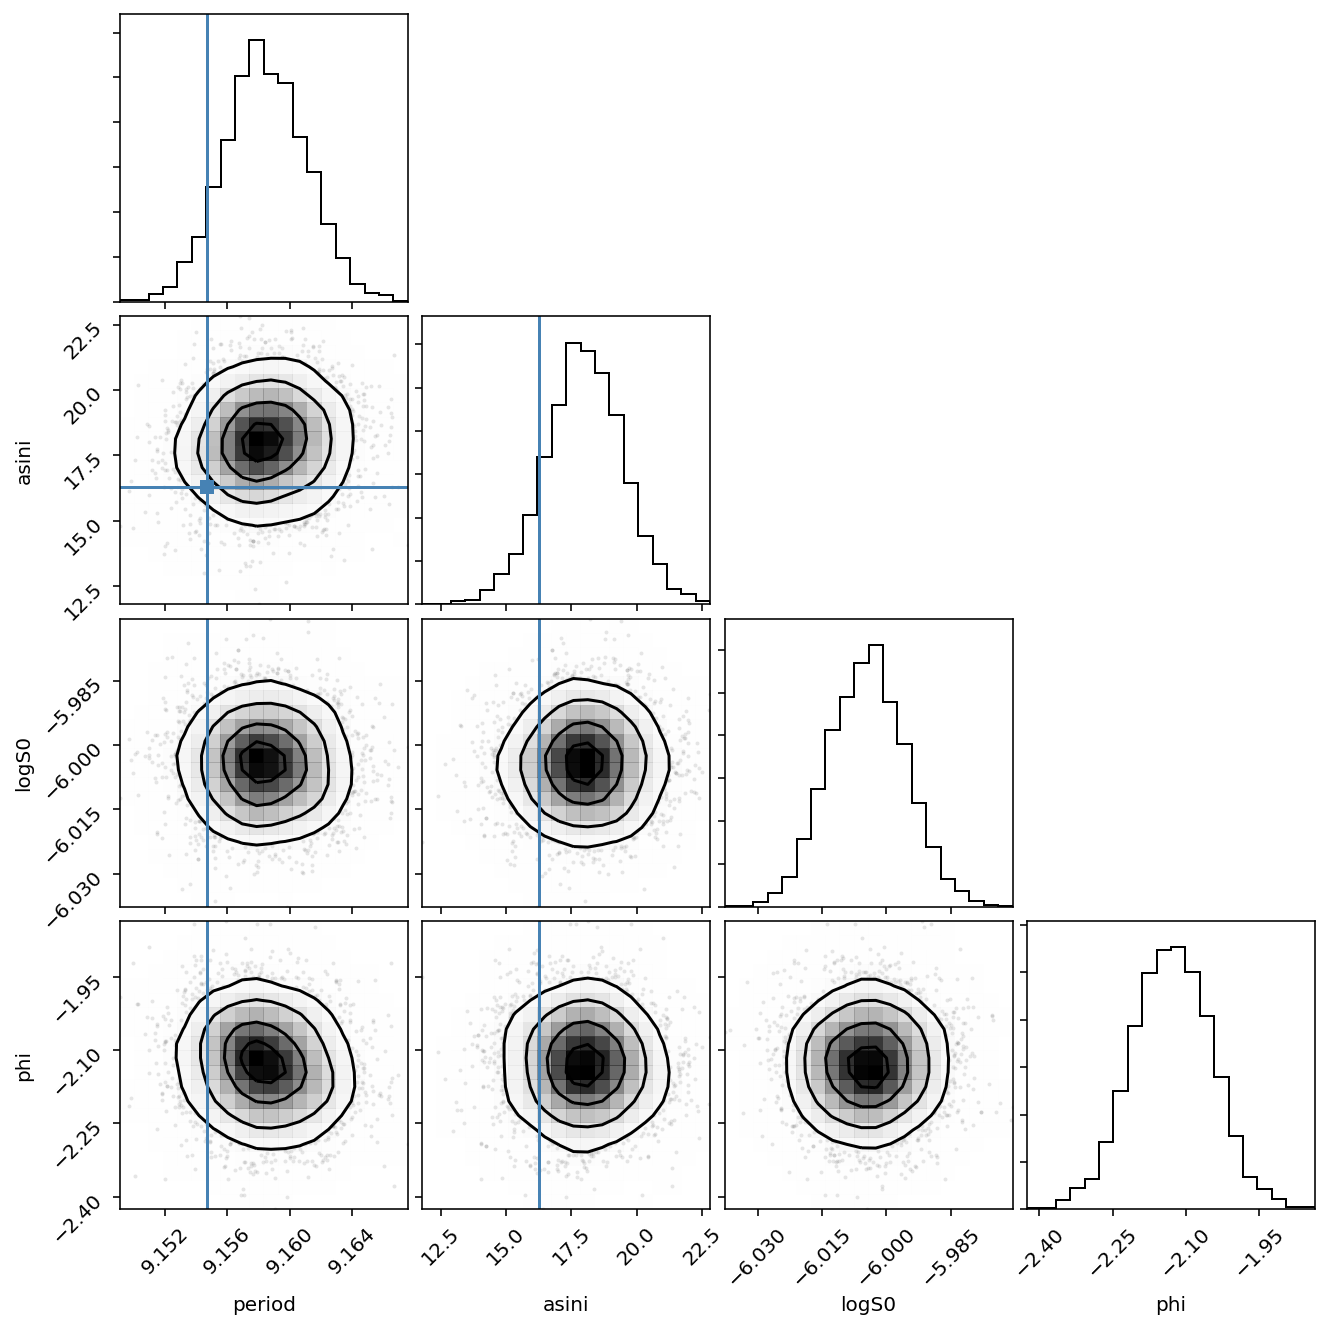

In [70]:
import corner

samples = pm.trace_to_dataframe(trace, 
                                varnames=['period', 'asini', 'logS0', 'phi']
                                #[v.name for v in model.vars]
                               )
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", "")] = samples[k]
        del samples[k]
        
corner.corner(samples, smooth=1, truths=[9.1547, 16.278, 0, 0,]);

In [63]:
from maelstrom.utils import mass_function
import astropy.units as u
mf = mass_function(trace['period'] * u.day, trace['asini'] * u.s)

In [64]:
np.mean(mf)

<Quantity 0.07606769 solMass>

In [164]:
rv_jd, rv_rv, rv_err = np.loadtxt('data/kic6780873_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd += 2400000
rv_jd -= 2454833
rv_jd -= ms.time_mid

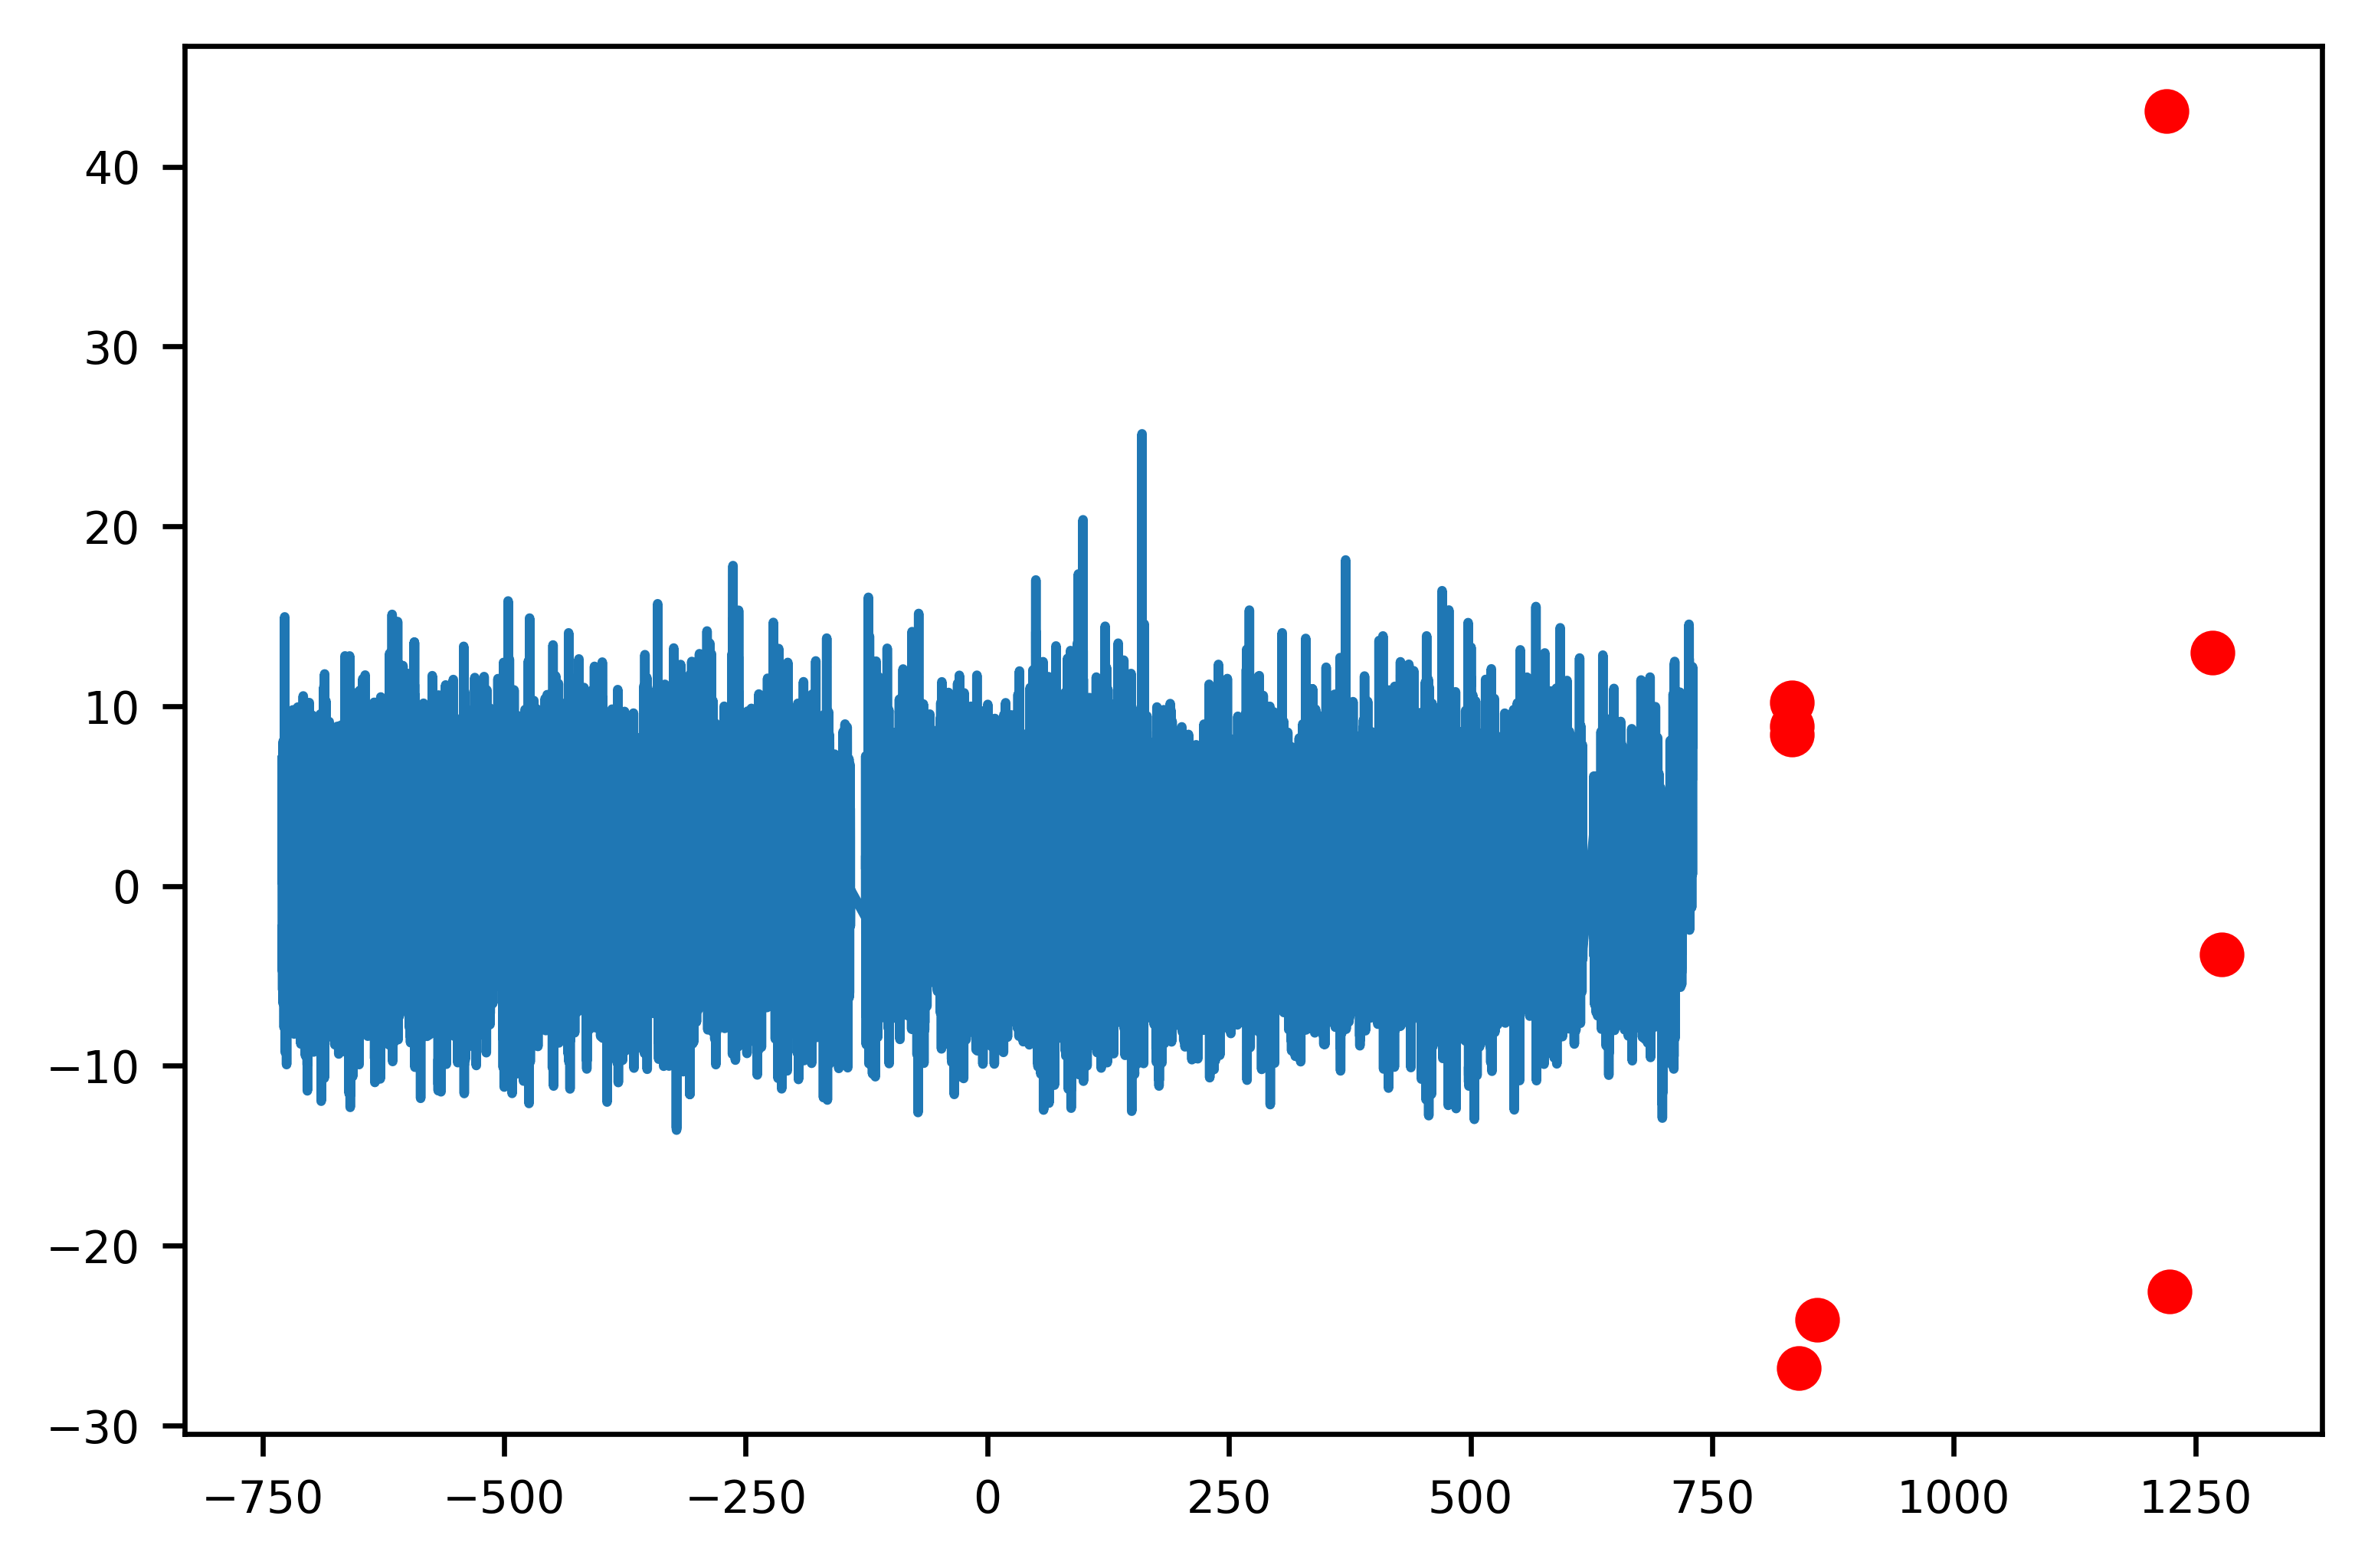

In [165]:
plt.plot(time, mag)
plt.scatter(rv_jd, rv_rv, c='r')

In [166]:
time, mag = ms.time, ms.flux
freq = ms.freq

In [219]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import pymc3 as pm
import theano

rv_time_tensor = theano.shared(rv_jd)
rv_rv_tensor = theano.shared(rv_rv)

weight = False

with pm.Model() as model:
    # It's much faster to sample from a log-space period
#     logP = pm.Normal("logP", mu=np.log(9.15), sd=3.)
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(9.15), sd=1.0,
                                      testval=np.log(9.15))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=0.)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(50))('logasini', mu=np.log(19.6), sd=1,
                                            testval=np.log(19.6))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega")
    #omega = pm.Uniform("omega", lower=0, upper=2*np.pi)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=0.003)

    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))

    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
                
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(ms.freq), sd=0.1, shape=len(ms.freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(ms.freq))
    log_min_amp = np.log(0.1 * np.std(mag))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(mag))
    log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=10.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
    gp_l = gp.log_likelihood(mag - full_lc)
    # Weight likelihood equally with RV data
    if weight:
        pm.Potential("obs", gp_l / (len(time) / len(rv_rv_tensor.get_value()))
                    )
    else:
        pm.Potential("obs", gp_l)
    #pm.Deterministic("gp_pred", gp.predict())

    #trace = pm.load_trace(directory='traces/6780873/')
    
    # RADIAL VELOCITIES
    logs_rv = pm.Normal('logs_RV_a', mu=0., sd=10)
    gammav = pm.Normal('gammav', mu=0., sd=100.)
    rv_mean_anom = (2.0 * np.pi * rv_time_tensor / period - phi)
    rv_true_anom = get_true_anomaly(rv_mean_anom, eccen + tt.zeros_like(rv_mean_anom))
    
    rv_vrad_a = -1 * ((asini / 86400) * (-2.0 * np.pi * (1 / period) * 
                                    (1/tt.sqrt(1.0 - tt.square(eccen))) * (tt.cos(rv_true_anom + omega) + eccen*tt.cos(omega))))
    rv_vrad_a *= 299792.458  # c in km/s
    rv_vrad_a += gammav

    pm.Normal("obs_radial_velocity_a", mu=rv_vrad_a, sd=tt.exp(logs_rv), observed=rv_rv_tensor)
    
    #trace = pm.load_trace('traces/6780873_with_rv/')

[phi_angle__, logs_lc, mean, omega_angle__, eccen_interval__, lognu, phase_angle__, logamp_interval__, logw0_interval__, logpower, logs_RV_a, gammav]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -428752.8125912721 -> -428752.798644188
optimizing logp for variables: ['logs_lc']
message: Desired error not necessarily achieved due to precision loss.
logp: -428752.798644188 -> -191223.92707809812
optimizing logp for variables: ['logw0_interval__', 'logpower']
message: Desired error not necessarily achieved due to precision loss.
logp: -191223.92707809812 -> -179976.31873242222
optimizing logp for variables: ['logamp_interval__', 'phase_angle__']
message: Desired error not necessarily achieved due to precision loss.
logp: -179976.31873242222 -> -170769.71261013043
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -170769.71261013043 -> -162668.99833

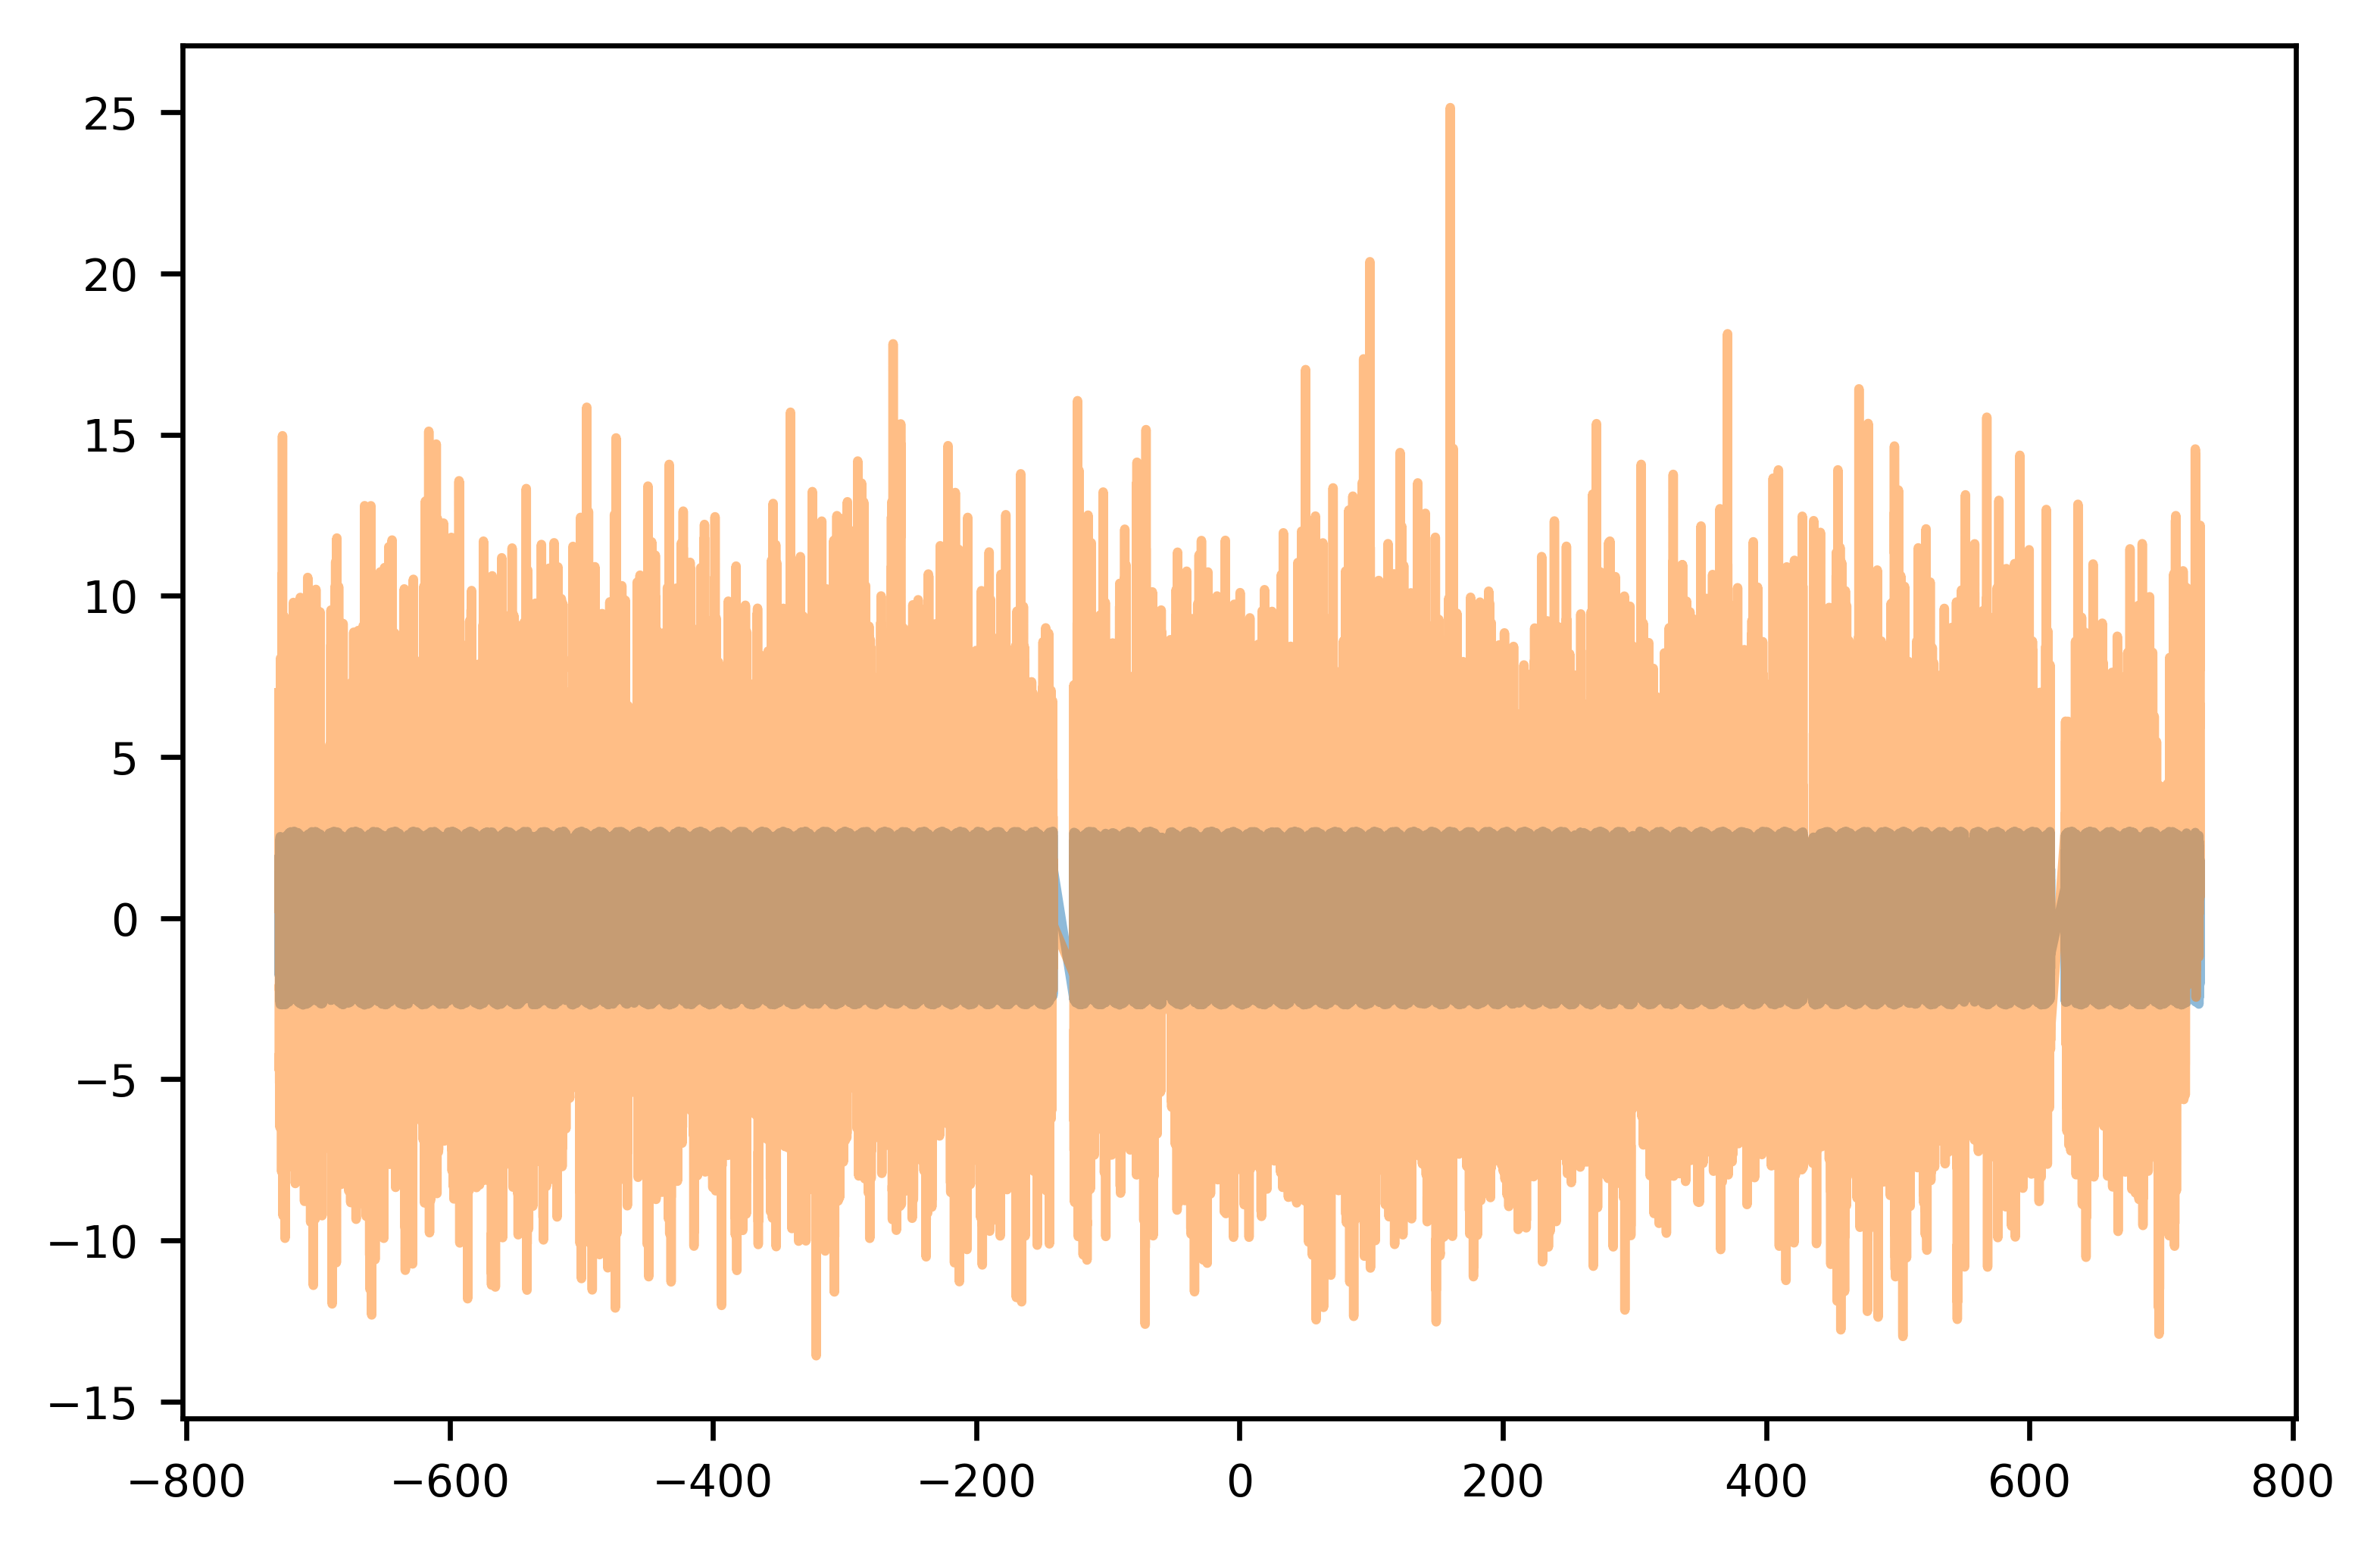

In [207]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

Text(0.5, 0, 'Time')

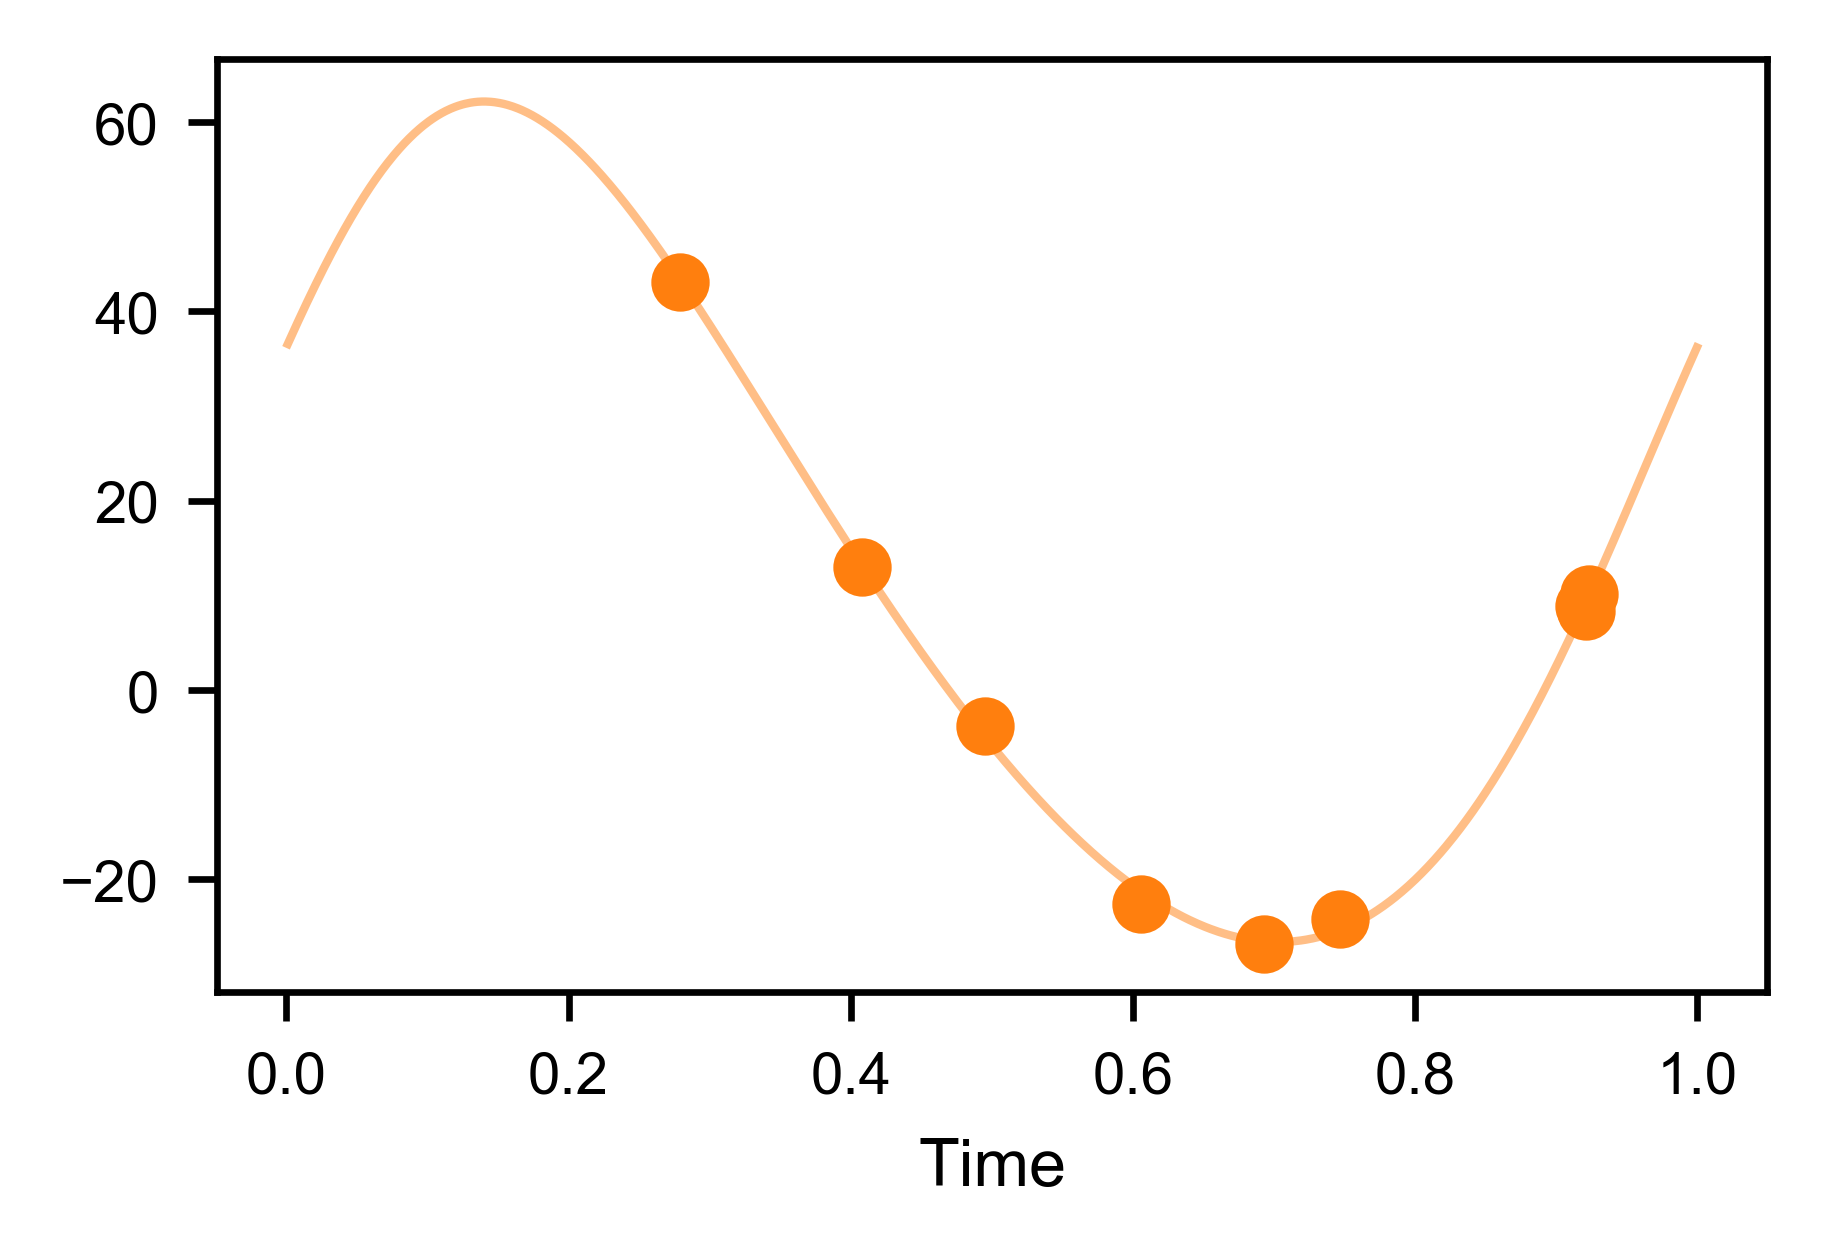

In [214]:
rv_time_tensor.set_value(np.linspace(rv_jd[0], rv_jd[-1], 1000))
rv_rv_tensor.set_value(np.zeros(len(rv_time_tensor.get_value())))

fig, ax = plt.subplots(figsize=mnras_size(240))

with model: 
    rv_sort_time = rv_time_tensor.get_value() % map_params['period'] /  map_params['period']
    sort = np.argsort(rv_sort_time)
    ax.plot(rv_sort_time[sort], xo.eval_in_model(rv_vrad_a, map_params)[sort], linewidth=1, alpha=0.5, c='C1', rasterized=True)
    ax.scatter(rv_jd % map_params['period'] /  map_params['period'], rv_rv, c='C1', label='RV data', rasterized=True)

plt.xlabel('Time')


In [215]:
map_params

{'logP_interval__': array(-1.03142758),
 'phi_angle__': array([1.0711339 , 4.34196636]),
 'logs_lc': array(-1.30812223),
 'logasini_interval__': array(-0.48370082),
 'mean': array(0.00797889),
 'omega_angle__': array([-3.27823877,  3.04189915]),
 'eccen_interval__': array(-1.85708436),
 'lognu': array([2.65237127, 2.5979628 ]),
 'phase_angle__': array([[ 3.31011184, -2.94037823],
        [-3.00718467,  3.36959582]]),
 'logamp_interval__': array([ 0.59810948, -0.44810629]),
 'logw0_interval__': array(1.2717285),
 'logpower': array(10.82302605),
 'logs_RV_a': array(-0.21222704),
 'gammav': array(13.71320465),
 'logP': array(2.21457439),
 'period': array(9.15751073),
 'phi': array(0.24186404),
 'logasini': array(2.91639029),
 'asini': array(18.47447945),
 'omega': array(-0.82277544),
 'eccen': array(0.13490821),
 'nu': array([14.18764155, 13.43633764]),
 'phase': array([ 2.30827917, -0.7174807 ]),
 'logamp': array([ 0.5492589 , -0.03885025]),
 'logw0': array(2.62792966),
 'logS0': array(0

In [216]:
import theano

with model:
    func = xo.utils.get_theano_function_for_var(model.logpt, profile=True)
#     func = xo.utils.get_theano_function_for_var(theano.grad(model.logpt, model.vars), profile=True)
    args = xo.utils.get_args_for_theano_function(model.test_point)
    print(func(*args))
    
    %timeit func(*args)

-967034.3470718806
22.2 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [217]:
func.profile.summary()

Function profiling
  Message: /Users/danielhey/anaconda3/lib/python3.7/site-packages/exoplanet/utils.py:35
  Time in 82 calls to Function.__call__: 1.807068e+00s
  Time in Function.fn.__call__: 1.800934e+00s (99.661%)
  Time in thunks: 1.786481e+00s (98.861%)
  Total compile time: 2.503970e+00s
    Number of Apply nodes: 149
    Theano Optimizer time: 9.097848e-01s
       Theano validate time: 2.858162e-02s
    Theano Linker time (includes C, CUDA code generation/compiling): 1.506456e+00s
       Import time 1.342201e-02s
       Node make_thunk time 1.499470e+00s
           Node Elemwise{Composite{Switch(EQ(i0, i1), (i2 + (i3 * i4)), i5)}}[(0, 4)](FactorOp{J=2, n_rhs=-1}.3, TensorConstant{0}, TensorConstant{-59540.78438193036}, TensorConstant{-0.5}, Sum{acc_dtype=float64}.0, TensorConstant{-inf}) time 1.384590e+00s
           Node Elemwise{Composite{((i0 / i1) - i2)}}(TensorConstant{[-4585.119...11986544]}, Elemwise{Exp}[(0, 0)].0, Elemwise{arctan2,no_inplace}.0) time 3.765106e-03s
    

In [ ]:
rv_time_tensor = theano.shared(rv_jd)
rv_rv_tensor = theano.shared(rv_rv)

sampler = xo.PyMC3Sampler(window=200, finish=500)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains:  58%|█████▊    | 89/154 [06:24<03:45,  3.47s/draws]

In [85]:
%run paper/notebooks/setup.py

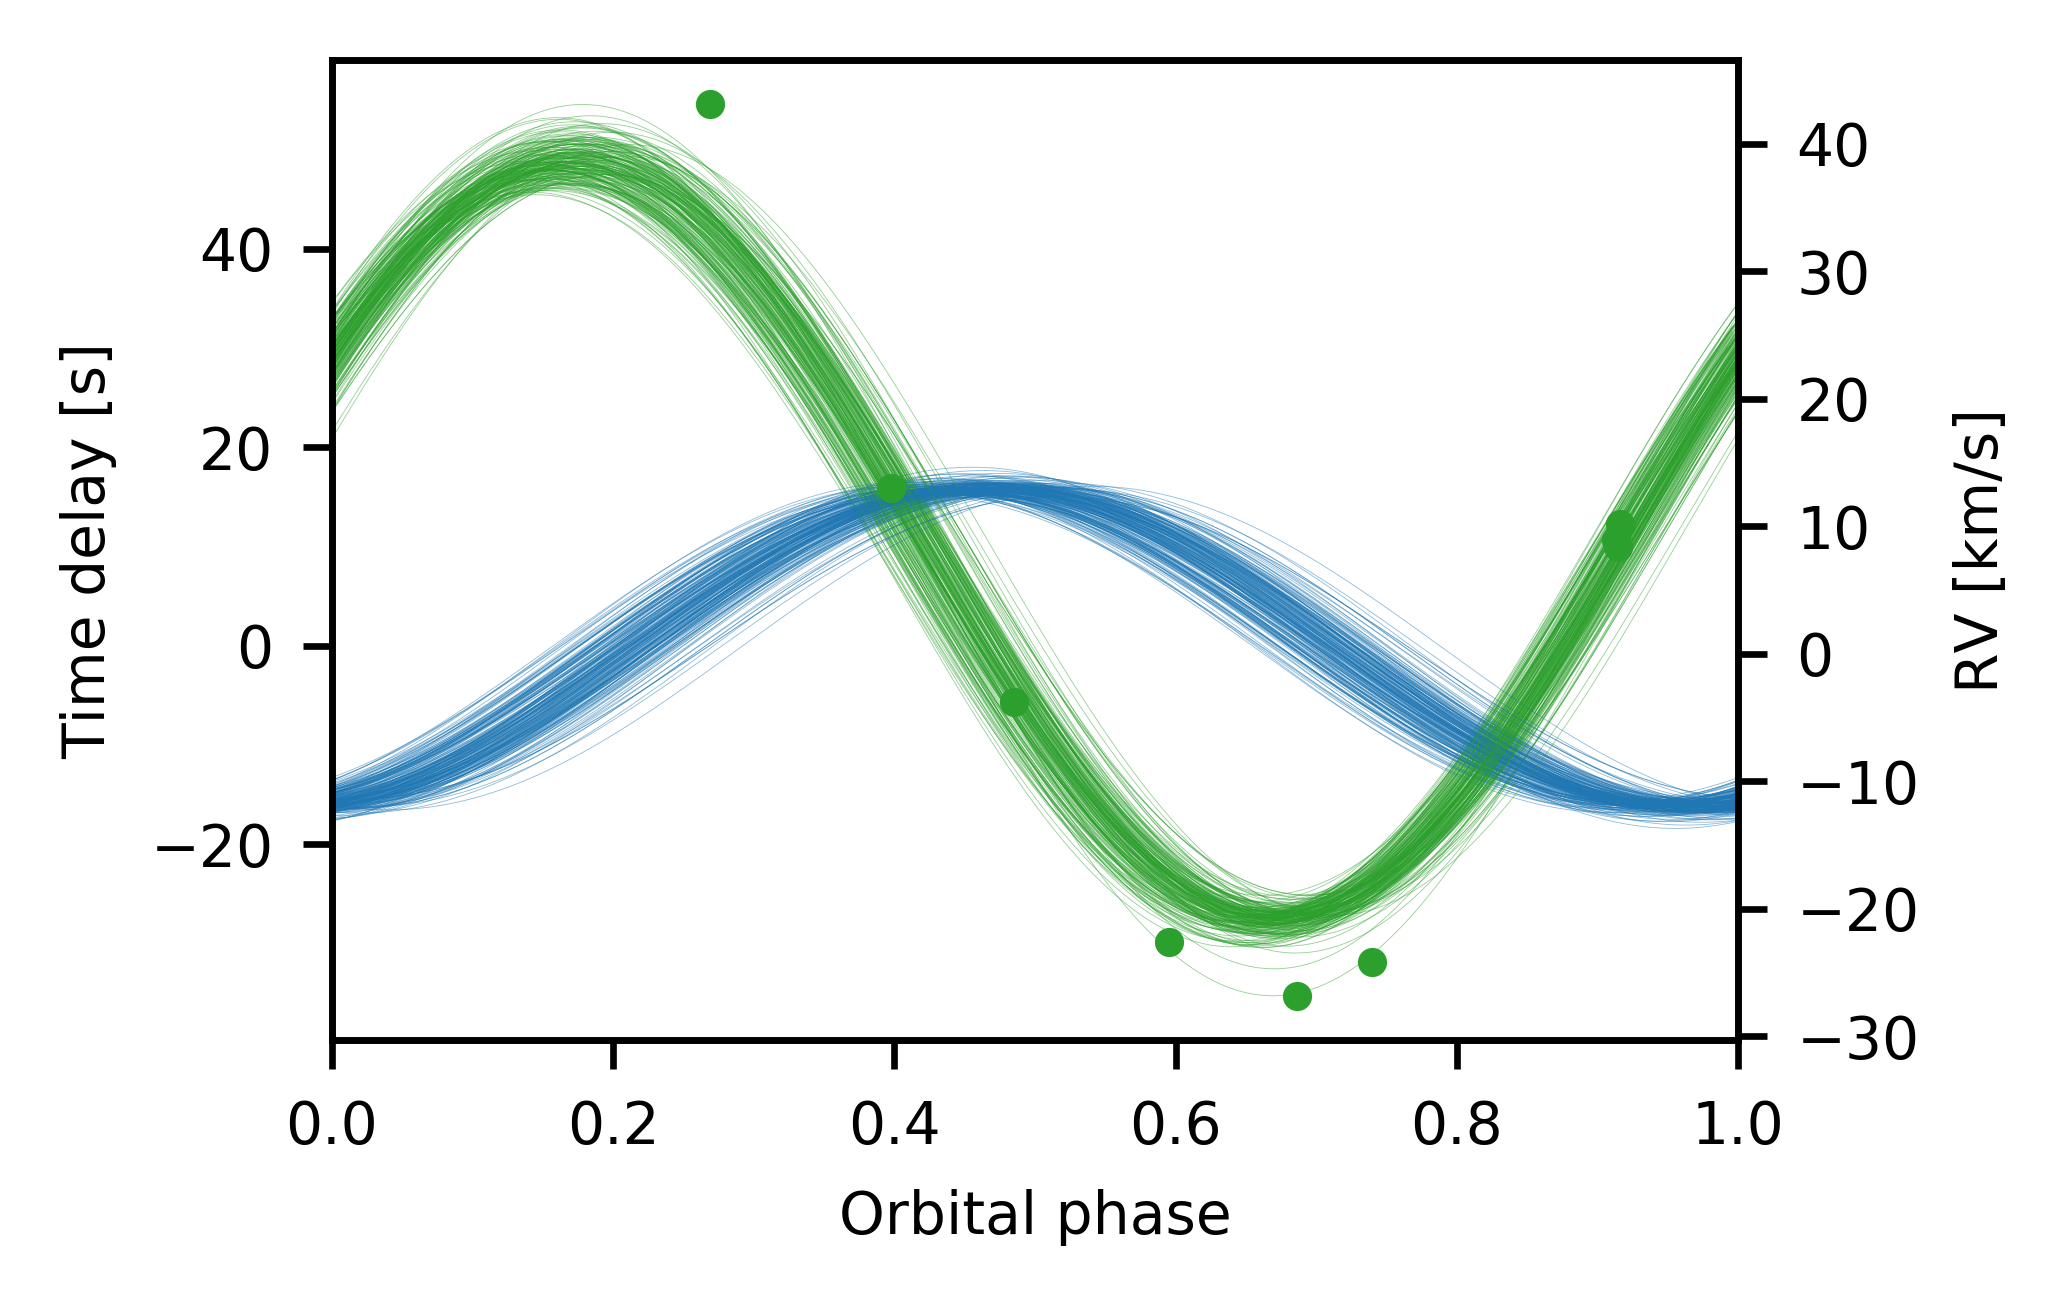

In [122]:
rv_time_tensor.set_value(np.linspace(rv_jd[0], rv_jd[-1], 1000))
rv_rv_tensor.set_value(np.zeros(len(rv_time_tensor.get_value())))

fig, ax = plt.subplots(figsize=mnras_size(240), constrained_layout=True)
ax2 = ax.twinx()

with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=200):
        taumod = xo.eval_in_model(asini * psi, samp)
        ttime = (ms.time_mid + time) % samp['period'] / samp['period']
        sort = np.argsort(ttime)
        ax.plot(ttime[sort], (taumod - np.mean(taumod))[sort], color="C0", linewidth=0.1, alpha=0.5, rasterized=True)
        
        
        rv_sort_time = rv_time_tensor.get_value() % samp['period'] /  samp['period']
        sort = np.argsort(rv_sort_time)
        ax.plot(rv_sort_time[sort], xo.eval_in_model(rv_vrad_a, samp)[sort], linewidth=0.1, alpha=0.5, c='C2',  
                rasterized=True)
    ax2.plot(rv_jd % np.median(trace['period']) /  np.median(trace['period']), rv_rv, '.', c='C2', label='RV data', rasterized=True, markersize=5)


ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay [s]')

ax2.set_ylabel('RV [km/s]')
ax.set_xlim(0, 1)
#a, b = ms.get_time_delay(segment_size=1)
#plt.scatter(a + ms.time_mid,b[:,0])

plt.savefig(overleaf_path + '6780873.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [82]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-1.308019,6.339924e-03,6.919597e-05,-1.319773,-1.295095,7861.548088,0.999793
mean,0.007495,4.417821e-02,4.789840e-04,-0.082278,0.089567,8266.894193,0.999750
lognu__0,2.652371,3.473699e-08,3.817908e-10,2.652371,2.652371,8115.362740,1.000040
lognu__1,2.597963,6.829102e-08,7.753426e-10,2.597963,2.597963,8340.952063,0.999896
logpower,10.823219,9.871053e-03,1.209500e-04,10.803876,10.842517,7766.323115,0.999752
logs_RV_a,0.490532,3.255380e-01,6.500745e-03,-0.091543,1.149302,2214.084061,1.001344
gammav,10.613972,8.702345e-01,1.362501e-02,8.913746,12.296139,3451.740041,1.000803
logP,2.214650,1.191822e-04,1.688462e-06,2.214426,2.214892,4139.179412,1.000127
period,9.158201,1.091495e-03,1.546328e-05,9.156154,9.160416,4139.102924,1.000127
phi,-2.077545,8.294445e-02,1.147632e-03,-2.250765,-1.928189,4280.931494,0.999919


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d314f60>,
      dtype=object)

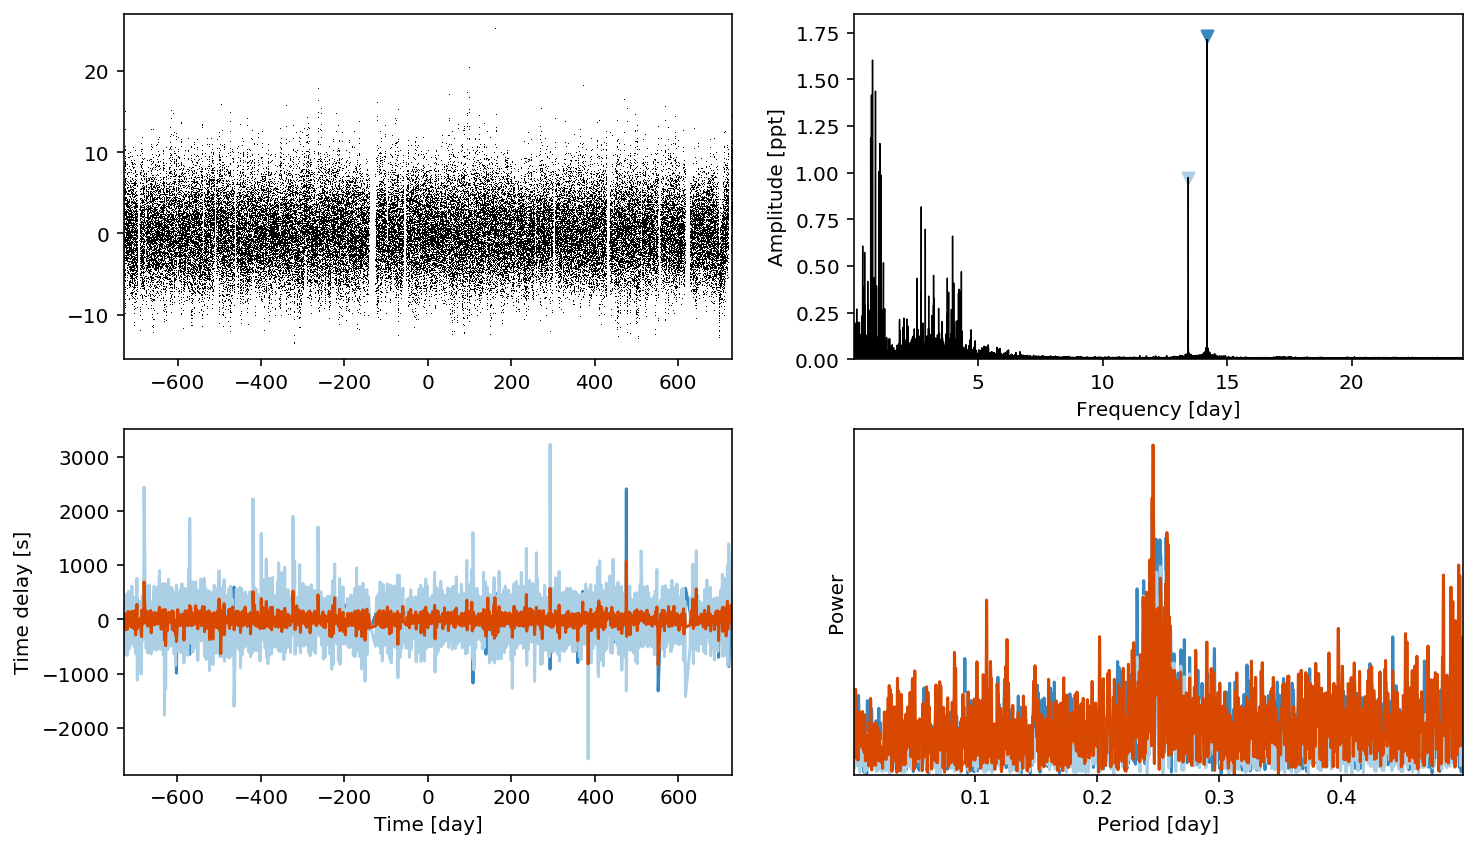

In [80]:
ms.first_look(segment_size=1.)

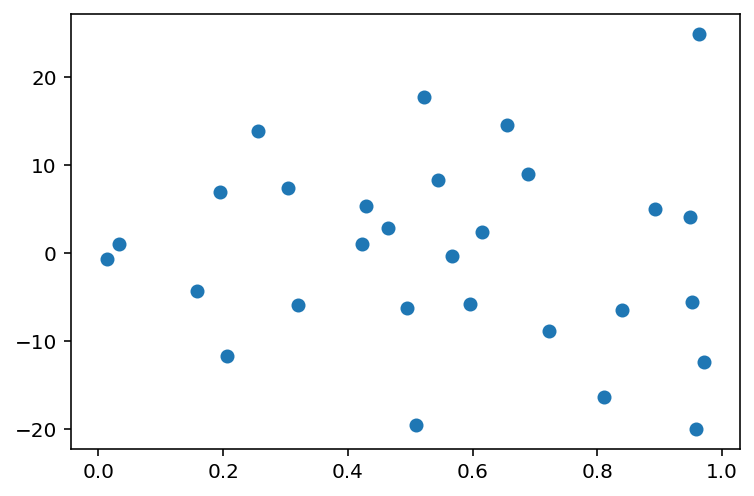

In [79]:
a, b = ms.get_time_delay(segment_size=50)

plt.scatter((a + ms.time_mid) % np.median(trace['period']) /  np.median(trace['period']), b[:,0])

ValueError: x and y must be the same size

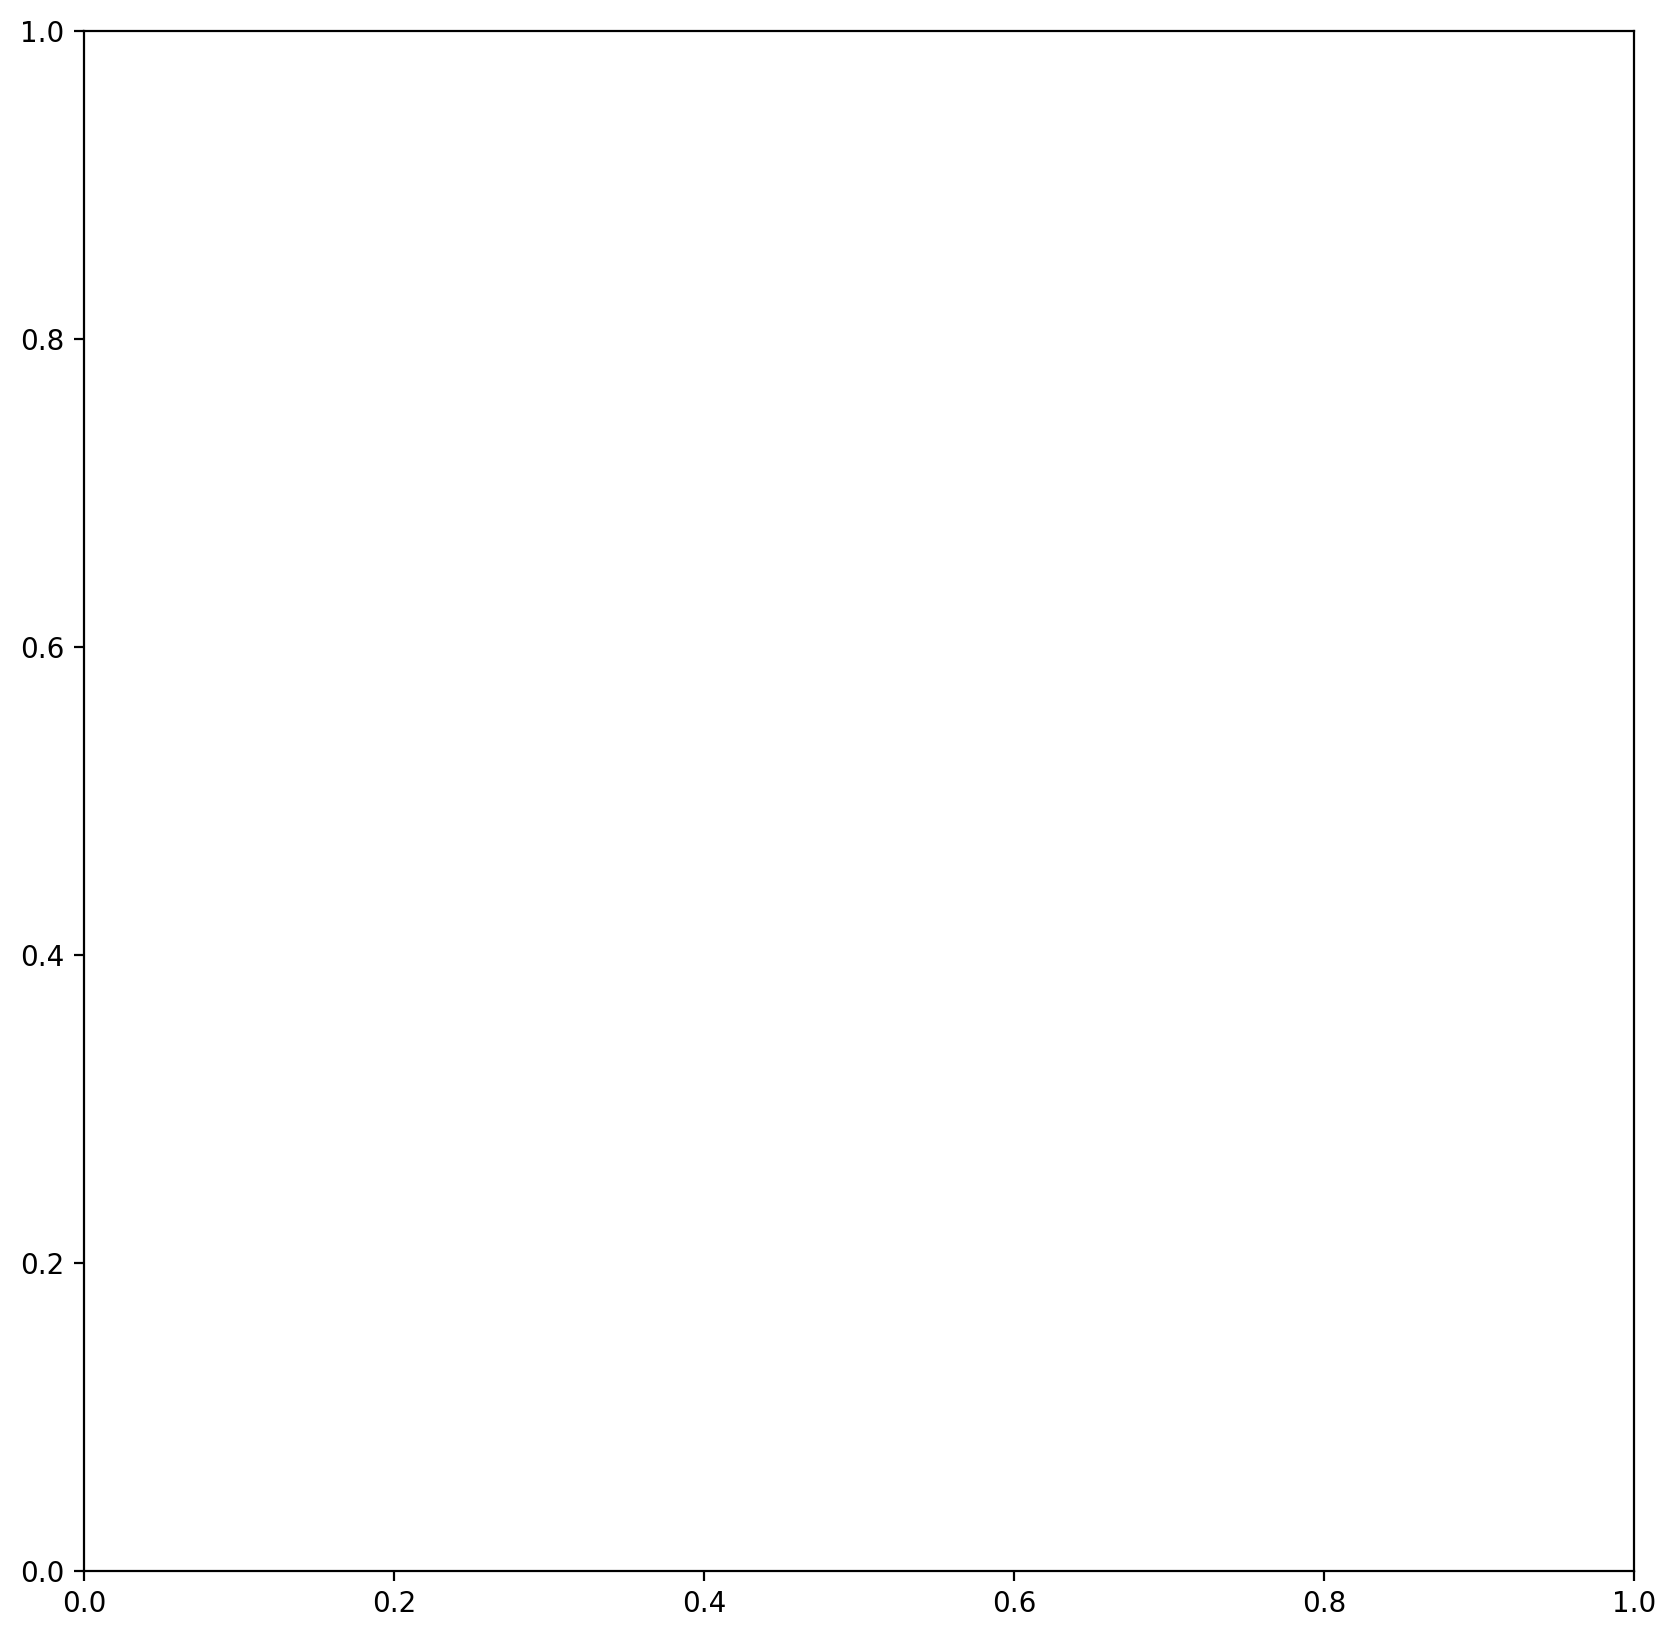

In [87]:
rv_time_tensor.set_value(np.linspace(rv_jd[0], rv_jd[-1], 1000))
rv_rv_tensor.set_value(np.zeros(len(rv_time_tensor.get_value())))

fig, axes = plt.subplots(1,1, figsize=[10,10])
with model:
    ax = axes
    ax.scatter(rv_time_tensor.get_value() % map_params['period'] /  map_params['period'], xo.eval_in_model(rv_vrad_a, map_params))
    ax.scatter(rv_jd % map_params['period'] /  map_params['period'], rv_rv, c='green', label='RV data')
    
    ax = ax.twinx()
    a, b = ms.get_time_delay(segment_size=3)
    ax.plot(a % map_params['period'] /  map_params['period'], b[:,0], '.', c='black')
    taumod = xo.eval_in_model(asini * psi, map_params)
    ax.scatter((ms.time_mid + time + 0) % map_params['period'] /  map_params['period'], taumod - np.mean(taumod), color="C0", linewidth=0.1)

In [88]:
map_params

{'logP_interval__': array(-1.0314865),
 'phi_angle__': array([-4.04460706, -1.90817475]),
 'logs_lc': array(-1.30810132),
 'logasini_interval__': array(-0.71697237),
 'mean': array(0.00798194),
 'lognu': array([2.65237127, 2.5979628 ]),
 'phase_angle__': array([[ 3.30157291, -2.93132084],
        [-3.01655137,  3.37748534]]),
 'logamp_interval__': array([ 0.59810318, -0.44809565]),
 'logw0_interval__': array(1.27173506),
 'logpower': array(10.82304981),
 'logs_RV_a': array(0.53087112),
 'gammav': array(11.57952478),
 'logP': array(2.2145481),
 'period': array(9.15727001),
 'phi': array(-2.01161618),
 'logasini': array(2.83057735),
 'asini': array(16.95524715),
 'nu': array([14.18764154, 13.43633763]),
 'phase': array([ 2.31111332, -0.71479481]),
 'logamp': array([ 0.54925558, -0.03884442]),
 'logw0': array(2.62793742),
 'logS0': array(0.31130015)}

In [89]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains: 100%|██████████| 1004/1004 [03:39<00:00,  3.63draws/s]


In [90]:
with model:
    trace = sampler.sample(draws=2000)

Sampling 2 chains: 100%|██████████| 4000/4000 [16:17<00:00,  3.31draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [91]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,-1.308019,6.339924e-03,6.919597e-05,-1.319773,-1.295095,7861.548088,0.999793
mean,0.007495,4.417821e-02,4.789840e-04,-0.082278,0.089567,8266.894193,0.999750
lognu__0,2.652371,3.473699e-08,3.817908e-10,2.652371,2.652371,8115.362740,1.000040
lognu__1,2.597963,6.829102e-08,7.753426e-10,2.597963,2.597963,8340.952063,0.999896
logpower,10.823219,9.871053e-03,1.209500e-04,10.803876,10.842517,7766.323115,0.999752
logs_RV_a,0.490532,3.255380e-01,6.500745e-03,-0.091543,1.149302,2214.084061,1.001344
gammav,10.613972,8.702345e-01,1.362501e-02,8.913746,12.296139,3451.740041,1.000803
logP,2.214650,1.191822e-04,1.688462e-06,2.214426,2.214892,4139.179412,1.000127
period,9.158201,1.091495e-03,1.546328e-05,9.156154,9.160416,4139.102924,1.000127
phi,-2.077545,8.294445e-02,1.147632e-03,-2.250765,-1.928189,4280.931494,0.999919


In [6]:
8.702345e-01

0.8702345

In [93]:
pm.save_trace(trace, directory='traces/6780873_with')

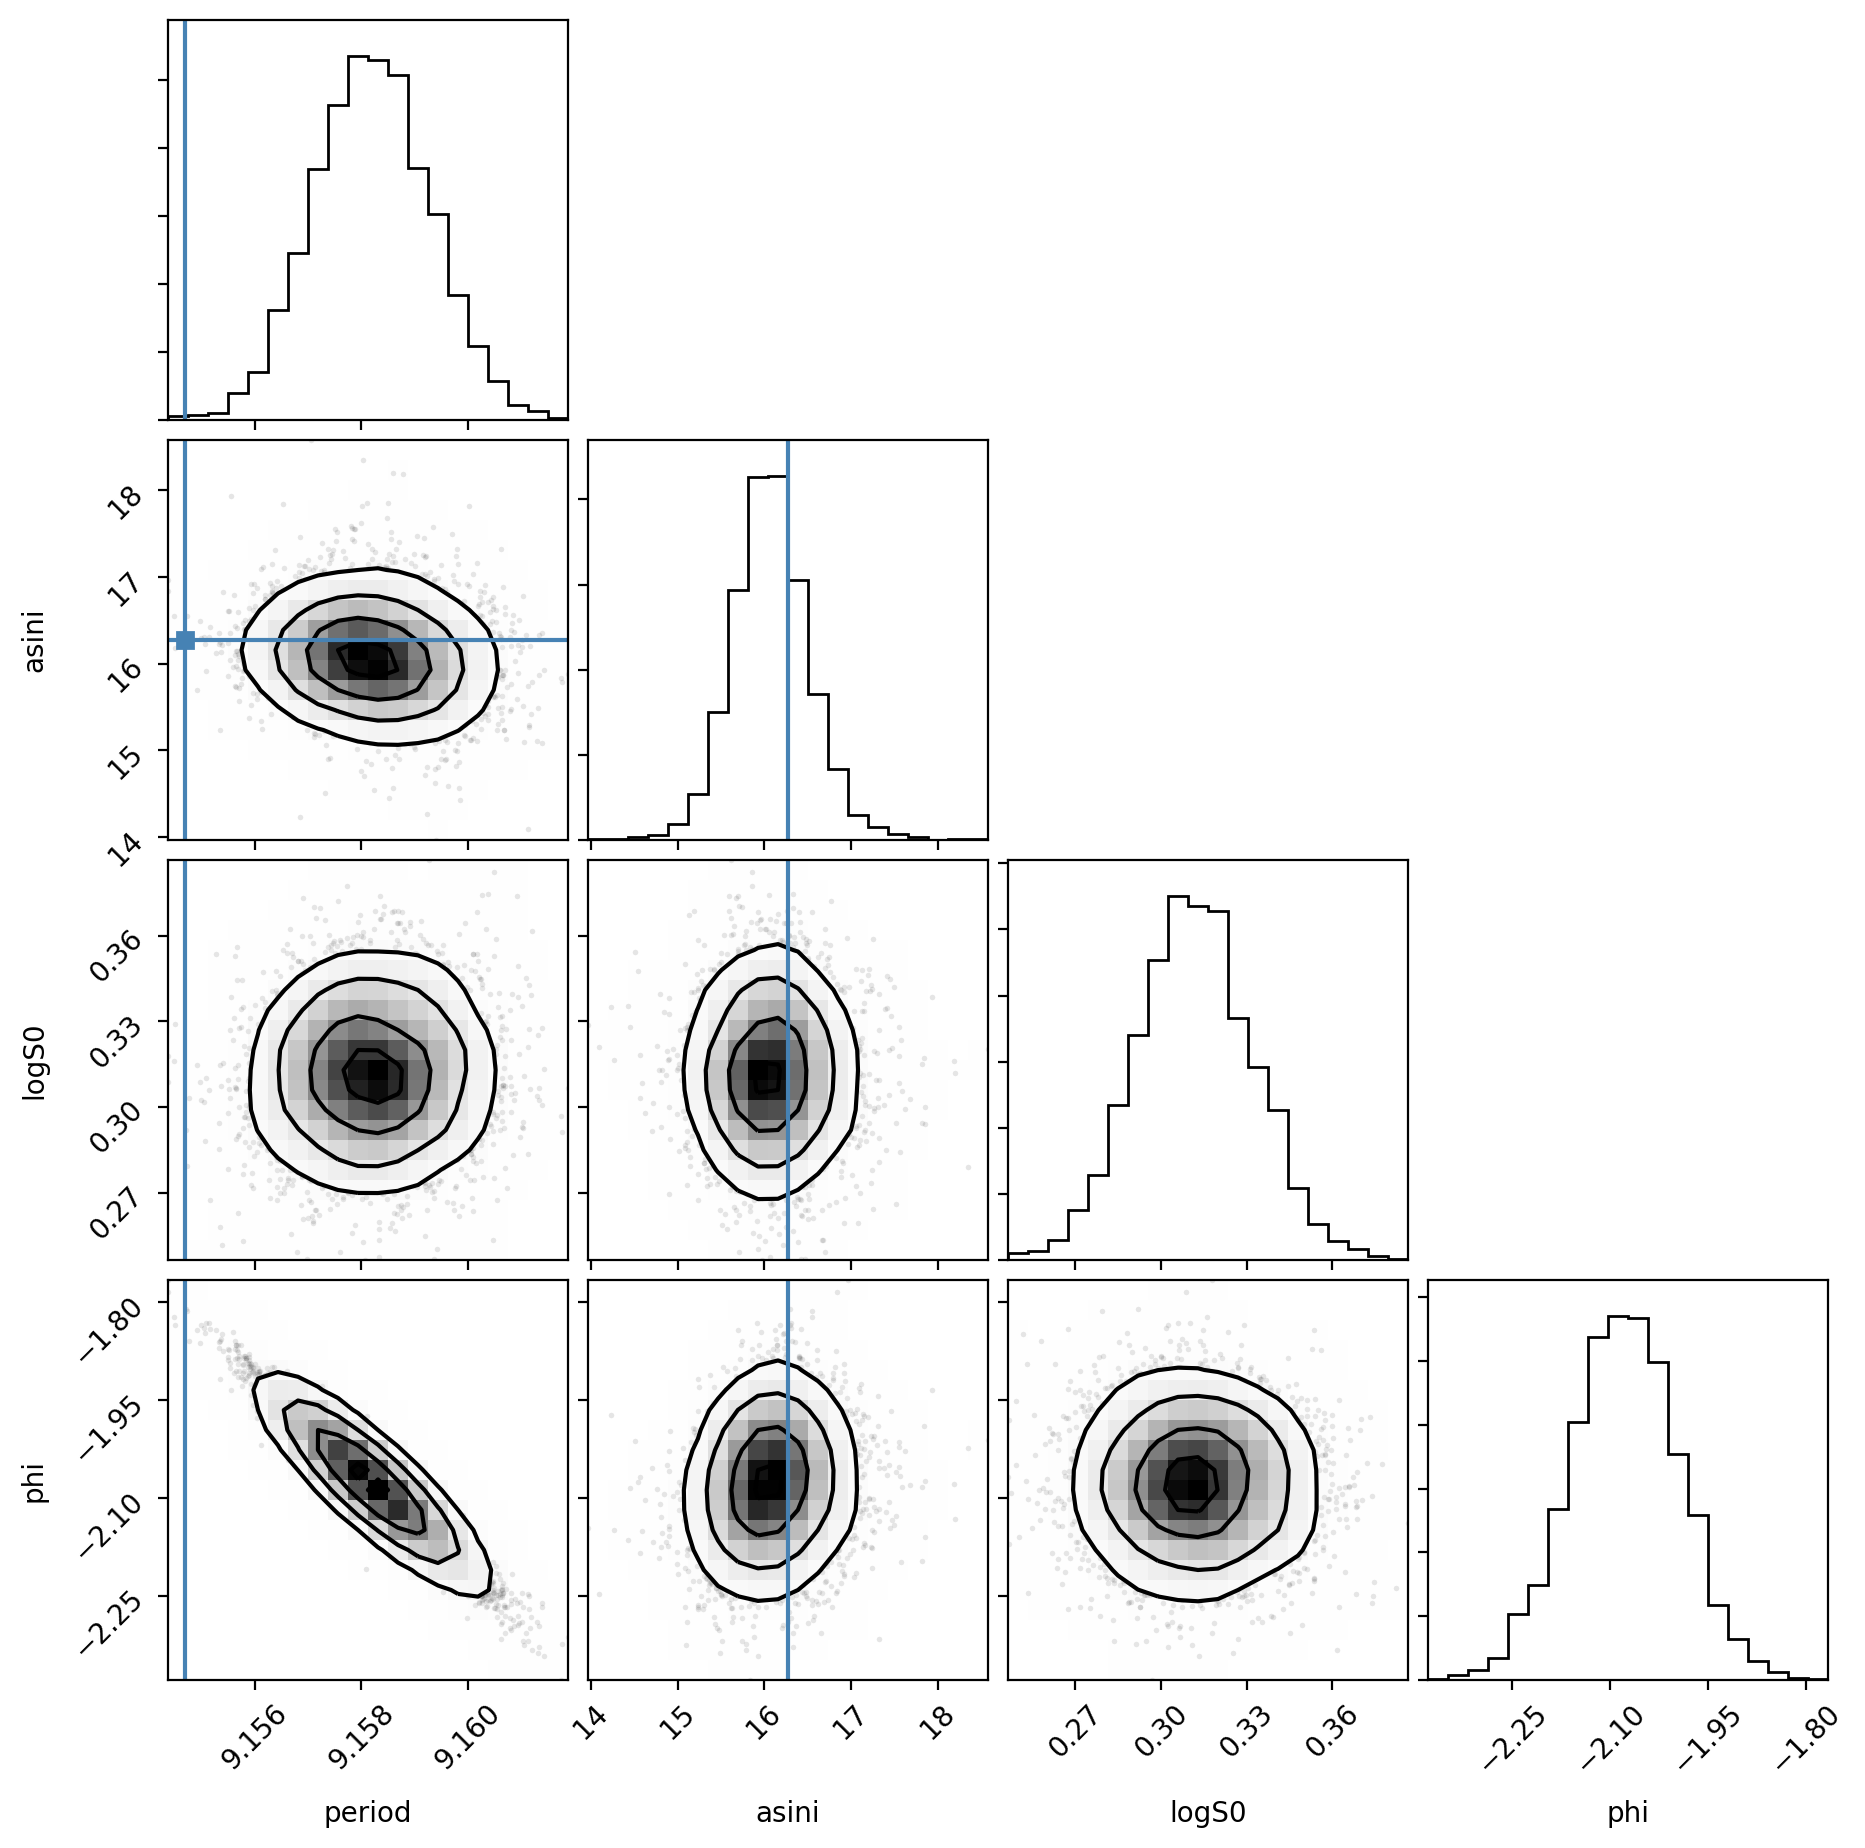

In [92]:
import corner

samples = pm.trace_to_dataframe(trace, 
                                varnames=['period', 'asini', 'logS0', 'phi']
                                #[v.name for v in model.vars]
                               )
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", "")] = samples[k]
        del samples[k]
        
corner.corner(samples, smooth=1, truths=[9.1547, 16.278, 0, 0,]);

In [35]:
with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=100):
        taumod = xo.eval_in_model(asini * psi, samp)
        ax.plot(ms.time_mid + time + xo.eval_in_model(phi * period / (2*np.pi), samp), taumod - np.mean(taumod), color="C0", linewidth=0.1)
        

{'logP_interval__': array(-1.0314865),
 'phi_angle__': array([-4.04460706, -1.90817475]),
 'logs_lc': array(-1.30810132),
 'logasini_interval__': array(-0.71697237),
 'mean': array(0.00798194),
 'lognu': array([2.65237127, 2.5979628 ]),
 'phase_angle__': array([[ 3.30157291, -2.93132084],
        [-3.01655137,  3.37748534]]),
 'logamp_interval__': array([ 0.59810318, -0.44809565]),
 'logw0_interval__': array(1.27173506),
 'logpower': array(10.82304981),
 'logs_RV_a': array(0.53087112),
 'gammav': array(11.57952478),
 'logP': array(2.2145481),
 'period': array(9.15727001),
 'phi': array(-2.01161618),
 'logasini': array(2.83057735),
 'asini': array(16.95524715),
 'nu': array([14.18764154, 13.43633763]),
 'phase': array([ 2.31111332, -0.71479481]),
 'logamp': array([ 0.54925558, -0.03884442]),
 'logw0': array(2.62793742),
 'logS0': array(0.31130015)}

In [40]:
import lightkurve as lk

lk.search_lightcurvefile('gam Pav')

SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  265488188 tess2018206045859-s0001-0000000265488188-0120-s_lc.fits Light curves      0.0

In [ ]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import pymc3 as pm
import theano

rv_time_tensor = theano.shared(rv_jd)
rv_rv_tensor = theano.shared(rv_rv)

with pm.Model() as model:
    # It's much faster to sample from a log-space period
#     logP = pm.Normal("logP", mu=np.log(9.15), sd=3.)
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(9.15), sd=1.0,
                                      testval=np.log(9.15))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
    drift_gradient = 0.0
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=0.)
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(50))('logasini', mu=np.log(19.6), sd=1,
                                            testval=np.log(19.6))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(ms.freq), sd=0.1, shape=len(ms.freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1 - drift_gradient))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(ms.freq))
    log_min_amp = np.log(0.1 * np.std(mag))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(mag))
    log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=10.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/0.1))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean

    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
#     pm.Deterministic("gp_pred", gp.predict())

    #trace = pm.load_trace(directory='traces/6780873/')
    
    # RADIAL VELOCITIES
    logs_rv = pm.Normal('logs_RV_a', mu=0., sd=10)
    gammav = pm.Normal('gammav', mu=0., sd=100.)
    rv_mean_anom = (2.0 * np.pi * rv_time_tensor.get_value() / period - phi)
    eccen = 0
    omega = 0
    rv_true_anom = get_true_anomaly(rv_mean_anom, eccen + tt.zeros_like(rv_mean_anom))
    
    rv_vrad_a = ((asini / 86400) * (-2.0 * np.pi * (1 / period) * 
                                    (1/tt.sqrt(1.0 - tt.square(eccen))) * (tt.cos(rv_true_anom + omega) + eccen*tt.cos(omega))))
    rv_vrad_a *= 299792.458  # c in km/s
    rv_vrad_a += gammav

    pm.Normal("obs_radial_velocity_a", mu=rv_vrad_a, sd=tt.exp(logs_rv), observed=rv_rv_tensor.get_value())